In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from rasterio.features import rasterize
from io import BytesIO
from owslib.wfs import WebFeatureService
import geemap
import ee
import rioxarray
import contextily as ctx
from shapely.geometry import box
import xarray as xr
import pandas as pd
import geohexgrid as ghg
from shapely.geometry import Point
from shapely.ops import unary_union
import rioxarray as rio
from pystac.item import Item
from shapely.geometry import shape

from pystac_client import Client
import requests
import os
from requests.auth import HTTPBasicAuth
import h5py
import earthaccess
import dask.array as da
from dask.delayed import delayed
from dask.diagnostics import ProgressBar
import matplotlib.colors as mcolors
from tqdm import tqdm
import plotly.graph_objects as go
import cdsapi
import json
import duckdb

USE_CRS = "EPSG:5347"  # posgar para esperanza
WEB_MERCATOR_CRS = "EPSG:3857"

DEFAULT_FIGSIZE = (12, 10)
MAP_PADDING = 500
PLASMA_CMAP = plt.cm.plasma

ee.Initialize()


def setup_base_map(
    figsize=None, bounds=None, boundary_gdf=None, padding_x=None, padding_y=None
):
    """Create figure and set up basic map boundaries with padding."""
    if figsize is None:
        figsize = DEFAULT_FIGSIZE
    if padding_x is None:
        padding_x = MAP_PADDING
    if padding_y is None:
        padding_y = MAP_PADDING

    if bounds is None and boundary_gdf is not None:
        bounds = boundary_gdf.total_bounds

    # Convert bounds to Web Mercator for basemap compatibility
    if bounds is not None:
        # Create a temporary GeoDataFrame with the bounds to reproject
        temp_bounds = gpd.GeoDataFrame(
            geometry=[box(bounds[0], bounds[1], bounds[2], bounds[3])], crs=USE_CRS
        )
        bounds_3857 = temp_bounds.to_crs(WEB_MERCATOR_CRS).total_bounds
    else:
        bounds_3857 = bounds

    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlim(bounds_3857[0] - padding_x, bounds_3857[2] + padding_x)
    ax.set_ylim(bounds_3857[1] - padding_y, bounds_3857[3] + padding_y)
    return fig, ax


def add_basemap(ax, zoom=13):
    """Add CartoDB basemap to the axes."""

    ctx.add_basemap(
        ax,
        source=ctx.providers.CartoDB.PositronNoLabels,
        zorder=0,
        zoom=zoom,
    )

    return ax


def add_north_arrow(ax, x=0.95, y=0.05, arrow_length=0.04):
    """Add a north arrow to the map."""
    ax.annotate(
        "N",
        xy=(x, y),
        xytext=(x, y - arrow_length),
        arrowprops=dict(facecolor="black", width=3, headwidth=10),
        ha="center",
        va="center",
        fontsize=14,
        xycoords=ax.transAxes,
    )


def add_boundary_outline(ax, boundary_gdf, crs="EPSG:3857"):
    """Add the outline of a boundary geodataframe to a map."""
    boundary_3857 = boundary_gdf.to_crs(crs)
    boundary_3857.plot(
        ax=ax,
        facecolor="none",
        edgecolor="black",
        linewidth=0.5,
        linestyle="--",
        legend=False,
        zorder=5,
    )


def create_consistent_map(title, boundary_gdf, bounds=None):
    """Create a map with consistent styling and basemap."""
    fig, ax = setup_base_map(bounds=bounds, boundary_gdf=boundary_gdf)

    add_basemap(ax)

    add_north_arrow(ax)

    add_boundary_outline(ax, boundary_gdf)

    ax.set_title(title, fontsize=16, fontweight="bold", pad=20)

    ax.set_axis_off()

    return fig, ax


def wfs_to_gdf(
    wfs_url: str, layer_name: str, srs: str = "EPSG:4326"
) -> gpd.GeoDataFrame:
    """
    Descarga una capa WFS y la devuelve como GeoDataFrame.

    Args:
        wfs_url (str): URL del servicio WFS.
        layer_name (str): Nombre de la capa (typename).
        srs (str): Código EPSG del sistema de referencia de coordenadas.

    Returns:
        gpd.GeoDataFrame: Capa descargada como GeoDataFrame.
    """
    wfs = WebFeatureService(url=wfs_url, version="2.0.0")
    response = wfs.getfeature(typename=layer_name, srsname=srs)
    gdf = gpd.read_file(BytesIO(response.read()))
    return gdf


parquet_path = "/home/nissim/Documents/dev/fulbright/ciut-riesgo/data/villa_del_rosario/datos/rio_segundo.parquet"
base_url = "https://wms.ign.gob.ar/geoserver/ign/ows"

if os.path.exists(parquet_path):
    # aoi = gpd.read_parquet(parquet_path)
    aoi = gpd.read_file(
        "/home/nissim/Documents/dev/fulbright/ciut-riesgo/data/villa_del_rosario/datos/coolviros/poligonal_coovilros.shp"
    )
    aoi = aoi.to_crs(USE_CRS)
    # Convert the union result back to a GeoDataFrame
    unioned_geometry = aoi.union_all()
    aoi = gpd.GeoDataFrame({"id": ["aoi"]}, geometry=[unioned_geometry], crs=USE_CRS)
else:
    dptos = wfs_to_gdf(wfs_url=base_url, layer_name="ign:departamento", srs="EPSG:4326")
    aoi = dptos[dptos["nam"] == "Río Segundo"]
    aoi = aoi.to_crs(USE_CRS)
    os.makedirs(os.path.dirname(parquet_path), exist_ok=True)
    aoi.to_parquet(parquet_path)

In [3]:
aoi.to_file(
    "/home/nissim/Documents/dev/fulbright/ciut-riesgo/data/villa_del_rosario/datos/coolviros/poligonal_coovilros.geojson"
)

<Axes: >

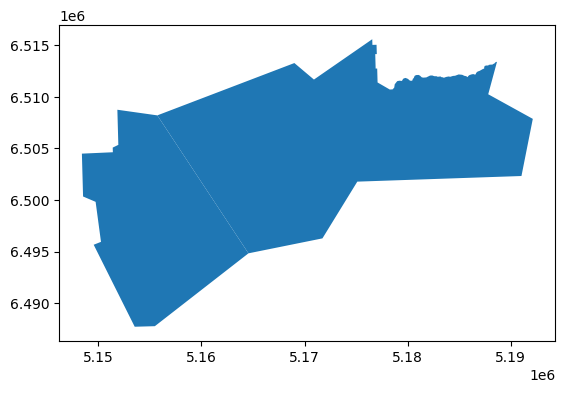

In [2]:
aoi.plot()

## Exposición y vulnerabilidad

In [ ]:
# Setup DuckDB and query
con = duckdb.connect()
for cmd in [
    "INSTALL spatial",
    "LOAD spatial",
    "INSTALL httpfs",
    "LOAD httpfs",
    "SET s3_region='us-east-2'",  # Note: different region for your data
]:
    con.execute(cmd)

temp_file = "privacion_data.parquet"

WGS84_CRS = "EPSG:4326"

bounds = aoi.to_crs(WGS84_CRS).total_bounds

query = f"""
COPY (
    WITH privacion_data AS (
        SELECT 
            id_geo,
            SUM(CASE WHEN valor_categoria IN ('2', '3', '4') THEN conteo ELSE 0 END) AS hogares_con_privacion,
            SUM(conteo) AS total_hogares,
            ROUND((hogares_con_privacion * 100.0) / total_hogares, 2) AS porcentaje_privacion
        FROM 's3://arg-fulbright-data/censo-argentino-2022/censo-2022-largo.parquet'
        WHERE codigo_variable = 'HOGAR_IPMH'
        GROUP BY id_geo
        HAVING total_hogares > 0
    )
    SELECT 
        g.cod_2022,
        g.prov,
        g.depto, 
        g.pob_tot_p,
        g.geometry,
        p.hogares_con_privacion,
        p.total_hogares,
        p.porcentaje_privacion
    FROM 's3://arg-fulbright-data/censo-argentino-2022/radios-2022.parquet' g
    JOIN privacion_data p ON g.cod_2022 = p.id_geo
    WHERE ST_XMax(g.geometry) >= {bounds[0]} 
      AND ST_XMin(g.geometry) <= {bounds[2]}
      AND ST_YMax(g.geometry) >= {bounds[1]} 
      AND ST_YMin(g.geometry) <= {bounds[3]}
) TO '{temp_file}' (FORMAT PARQUET);
"""

con.execute(query)
df = pd.read_parquet(temp_file)
df["geometry"] = gpd.GeoSeries.from_wkb(df["geometry"])
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="4326")
gdf = gdf.to_crs(USE_CRS)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

<Axes: >

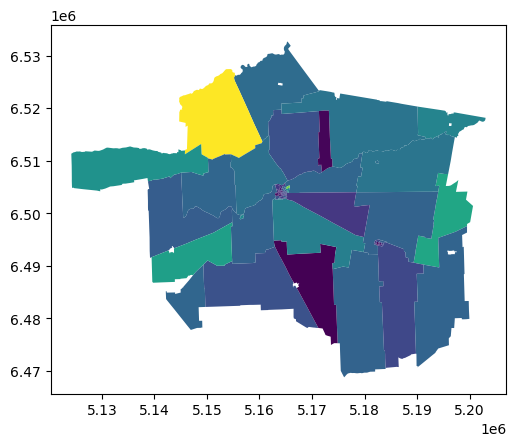

In [43]:
gdf.plot("porcentaje_privacion")

In [ ]:
# https://stac.openlandmap.org/pop.count_ghs.jrc/pop.count_ghs.jrc_20210101_20211231/pop.count_ghs.jrc_20210101_20211231.json

In [ ]:
# https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_POP_GLOBE_R2023A/GHS_POP_E2025_GLOBE_R2023A_54009_100/V1-0/tiles/GHS_POP_E2025_GLOBE_R2023A_54009_100_V1_0_R13_C13.zip

In [44]:
ghsl_ruta = "/home/nissim/Documents/dev/fulbright/ciut-riesgo/notebooks/data/GHS_POP_E2025_GLOBE_R2023A_54009_100_V1_0_R13_C13/GHS_POP_E2025_GLOBE_R2023A_54009_100_V1_0_R13_C13.tif"

ghsl = rioxarray.open_rasterio(
    ghsl_ruta,
    chunks={"x": 1024, "y": 1024},
)

ghsl = ghsl.rio.reproject(dst_crs=USE_CRS)

ghsl_clipped = ghsl.rio.clip(
    [aoi.geometry.iloc[0]],
    from_disk=True,
)

ghsl_masked = ghsl_clipped.where(ghsl_clipped > 0)

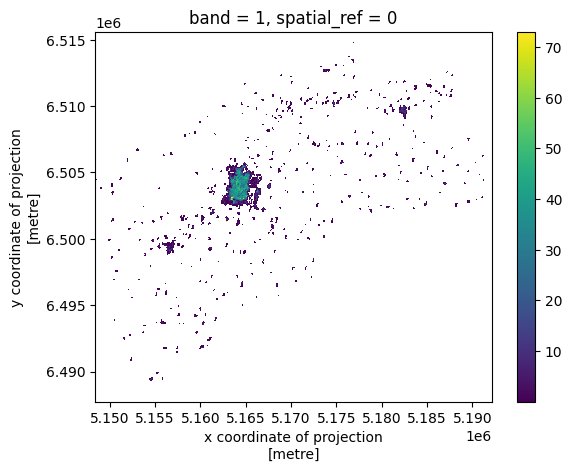

In [45]:
ghsl_masked.plot()

In [46]:
raster_referencia = ghsl_clipped
transformacion_referencia = raster_referencia.rio.transform()
crs_referencia = raster_referencia.rio.crs
forma_referencia = raster_referencia.shape[1:]
raster_ghsl = ghsl_clipped.values[0]

geometrias = [geom for geom in gdf.geometry]

# Option 1: Use the same method for both
# Replace zonal_stats with rasterize-based calculation
raster_ghsl_full = rasterize(
    [(geom, i + 1) for i, geom in enumerate(gdf.geometry)],
    out_shape=forma_referencia,
    transform=transformacion_referencia,
    fill=0,
    all_touched=True,
    dtype=np.int32,
)

# Calculate totals from the rasterized version
totales_ghsl = []
for i in range(len(gdf.geometry)):
    polygon_mask = raster_ghsl_full == (i + 1)  # +1 because rasterize starts at 1

    # Apply both polygon mask AND exclude nodata values
    valid_mask = polygon_mask & (raster_ghsl > 0) & (raster_ghsl != -200)

    total = np.sum(raster_ghsl[valid_mask]) if np.any(valid_mask) else 0
    totales_ghsl.append(total)

gdf["estimacion_pob_ghsl"] = totales_ghsl


geometrias_ghsl = [
    (geom, valor)
    for geom, valor in zip(
        gdf.geometry,
        gdf["estimacion_pob_ghsl"],
    )
]
geometrias_pob = [(geom, valor) for geom, valor in zip(gdf.geometry, gdf["POB_TOT_P"])]

raster_pob_ghsl = rasterize(
    geometrias_ghsl,
    out_shape=forma_referencia,
    transform=transformacion_referencia,
    fill=0,
    dtype=np.float32,
    all_touched=True,
)

raster_pob_censo = rasterize(
    geometrias_pob,
    out_shape=forma_referencia,
    transform=transformacion_referencia,
    fill=0,
    dtype=np.float32,
    all_touched=True,
)


mascara = (raster_ghsl > 0) & (raster_ghsl != -200) & (raster_pob_ghsl > 0.1)
ghsl_fraccional = np.full_like(raster_ghsl, 0, dtype=np.float64)
ghsl_fraccional[mascara] = raster_ghsl[mascara] / raster_pob_ghsl[mascara]

mascara2 = (ghsl_fraccional > 0) & (raster_pob_censo > 0)
pob_redistribuida = np.full_like(raster_ghsl, 0, dtype=np.float64)
pob_redistribuida[mascara2] = ghsl_fraccional[mascara2] * raster_pob_censo[mascara2]

pob_redistribuida_da = xr.DataArray(
    pob_redistribuida,
    coords={"y": ghsl_clipped.y, "x": ghsl_clipped.x},
    dims=["y", "x"],
    attrs=ghsl_clipped.attrs.copy(),
)

pob_redistribuida_da = pob_redistribuida_da.rio.write_crs(USE_CRS)

pob_redistribuida_enmascarada = pob_redistribuida_da.where(pob_redistribuida_da > 0)

total_redistribuido = pob_redistribuida[pob_redistribuida > 0].sum()
total_censo = gdf["POB_TOT_P"].sum()

In [47]:
# Create poverty proportions raster at 100m resolution
geometrias_privacion = [
    (geom, valor)
    for geom, valor in zip(
        gdf.geometry,
        gdf["porcentaje_privacion"] / 100,  # Convert percentage to proportion
    )
]

raster_privacion = rasterize(
    geometrias_privacion,
    out_shape=forma_referencia,
    transform=transformacion_referencia,
    fill=0,
    dtype=np.float32,
    all_touched=True,
)

# Create population in poverty raster by multiplying redistributed population by poverty proportions
mascara_pob_privacion = (pob_redistribuida > 0) & (raster_privacion > 0)
pob_privacion = np.full_like(pob_redistribuida, 0, dtype=np.float64)
pob_privacion[mascara_pob_privacion] = (
    pob_redistribuida[mascara_pob_privacion] * raster_privacion[mascara_pob_privacion]
)

# Create xarray DataArray for the poverty population raster
pob_privacion_da = xr.DataArray(
    pob_privacion,
    coords={"y": ghsl_clipped.y, "x": ghsl_clipped.x},
    dims=["y", "x"],
    attrs=ghsl_clipped.attrs.copy(),
)

pob_privacion_da = pob_privacion_da.rio.write_crs(USE_CRS)

# Mask zero values
pob_privacion_enmascarada = pob_privacion_da.where(pob_privacion_da > 0)

# Calculate total population in poverty
total_pob_privacion = pob_privacion[pob_privacion > 0].sum()
print(f"Total population in poverty: {total_pob_privacion:,.0f}")
print(
    f"Percentage of redistributed population in poverty: {(total_pob_privacion / total_redistribuido) * 100:.1f}%"
)

Total population in poverty: 5,597
Percentage of redistributed population in poverty: 28.3%


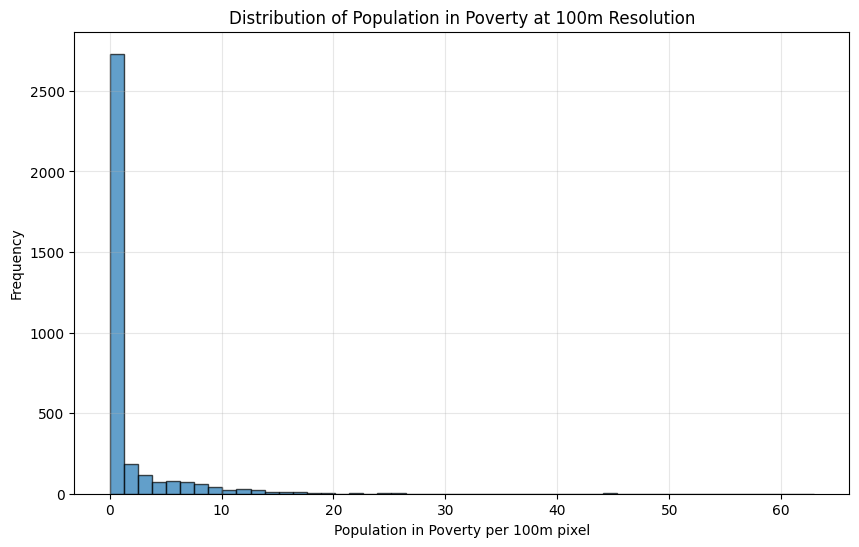

In [48]:
# Histogram of poverty population values
plt.figure(figsize=(10, 6))
pob_privacion_values = pob_privacion[pob_privacion > 0]
plt.hist(pob_privacion_values, bins=50, alpha=0.7, edgecolor="black")
plt.xlabel("Population in Poverty per 100m pixel")
plt.ylabel("Frequency")
plt.title("Distribution of Population in Poverty at 100m Resolution")
plt.grid(True, alpha=0.3)
plt.show()

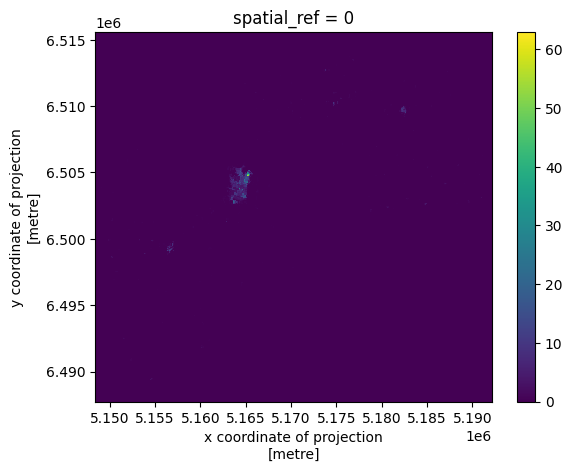

In [49]:
pob_privacion_da.plot()

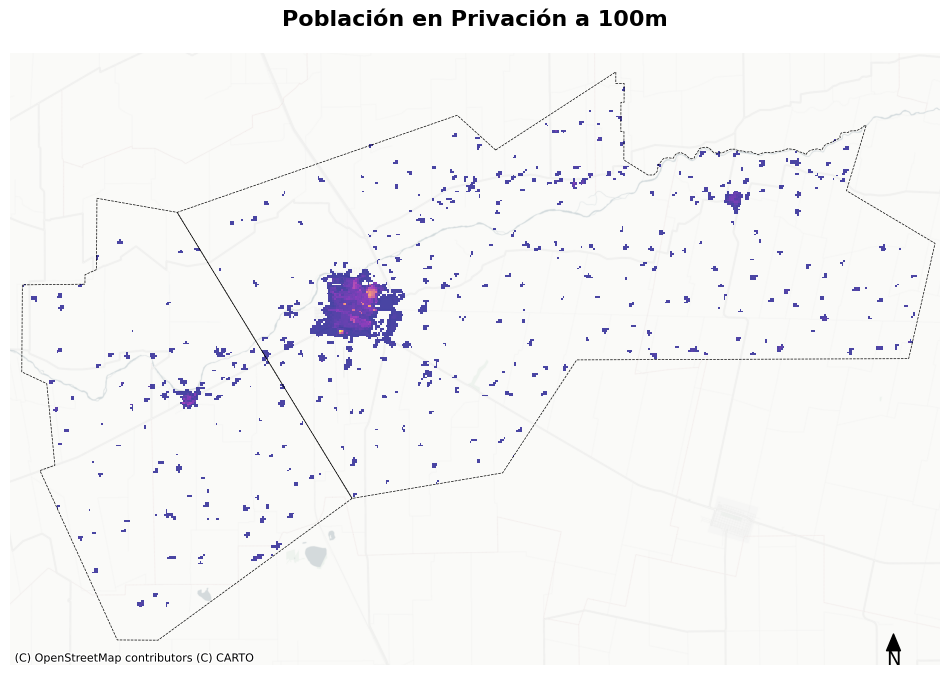

In [23]:
# Map of population in poverty at 100m resolution
fig, ax = create_consistent_map("Población en Privación a 100m", aoi)

pob_privacion_3857 = pob_privacion_enmascarada.rio.reproject(WEB_MERCATOR_CRS)
pob_privacion_3857 = pob_privacion_3857.where(pob_privacion_3857 > 0)

pob_privacion_3857.plot(
    ax=ax, cmap=PLASMA_CMAP, alpha=0.75, add_colorbar=False, add_labels=False, zorder=2
)

plt.title("Población en Privación a 100m", fontsize=16, fontweight="bold", pad=20)
plt.show()

## Incendios

In [9]:
# Create lists of all available years
modis_years = list(range(2000, 2021))  # 2000-2020
viirs_years = list(range(2012, 2022))  # 2012-2021


# Function to create FeatureCollection for a specific year and dataset
def create_fire_collection(dataset, year):
    """Create a FeatureCollection for a specific dataset and year"""
    if dataset == "modis":
        path = f"projects/sat-io/open-datasets/MODIS_MCD14DL/MCD14DL_{year}"
    elif dataset == "viirs":
        path = f"projects/sat-io/open-datasets/VIIRS/VNP14IMGTDL_NRT_{year}"
    else:
        raise ValueError("Dataset must be 'modis' or 'viirs'")

    try:
        return ee.FeatureCollection(path)
    except Exception as e:
        print(f"Warning: Could not load {dataset} data for year {year}: {e}")
        return None


# Load all MODIS data (2000-2020)
print("Loading MODIS data (2000-2020)...")
modis_collections = []
for year in modis_years:
    collection = create_fire_collection("modis", year)
    if collection is not None:
        modis_collections.append(collection)

# Load all VIIRS data (2012-2021)
print("Loading VIIRS data (2012-2021)...")
viirs_collections = []
for year in viirs_years:
    collection = create_fire_collection("viirs", year)
    if collection is not None:
        viirs_collections.append(collection)

# Combine all collections into single FeatureCollections
print("Combining all years...")
all_modis = ee.FeatureCollection(modis_collections).flatten()
all_viirs = ee.FeatureCollection(viirs_collections).flatten()

# Filter by area of interest
ee_aoi = geemap.geopandas_to_ee(aoi)

print("Filtering by area of interest...")
all_modis_aoi = all_modis.filterBounds(ee_aoi)
all_viirs_aoi = all_viirs.filterBounds(ee_aoi)

Loading MODIS data (2000-2020)...
Loading VIIRS data (2012-2021)...
Combining all years...
Filtering by area of interest...


In [10]:
# Get a color from a day or night
class_color = ee.Dictionary({"D": "0565A6", "N": "229A00"})

classes = ["D", "N"]


def add_style(pt):
    """Add styling properties to each point based on brightness and day/night"""
    size = ee.Number(pt.get("bright_ti4")).divide(100)
    color = class_color.get(pt.get("daynight"))
    return pt.set("styleProperty", ee.Dictionary({"pointSize": size, "color": color}))


# Style both MODIS and VIIRS data
modis_styled = all_modis_aoi.map(add_style)
viirs_styled = all_viirs_aoi.map(add_style)

# Create day and night fire layers for MODIS
modis_daytime = modis_styled.filter(ee.Filter.eq("daynight", "D")).style(
    styleProperty="styleProperty", neighborhood=50
)

modis_nighttime = modis_styled.filter(ee.Filter.eq("daynight", "N")).style(
    styleProperty="styleProperty", neighborhood=50
)

# Create day and night fire layers for VIIRS
viirs_daytime = viirs_styled.filter(ee.Filter.eq("daynight", "D")).style(
    styleProperty="styleProperty", neighborhood=50
)

viirs_nighttime = viirs_styled.filter(ee.Filter.eq("daynight", "N")).style(
    styleProperty="styleProperty", neighborhood=50
)

In [28]:
# Create the map
m = geemap.Map()

# Add all fire layers
m.addLayer(modis_daytime, {}, "MODIS Daytime Fires", True, 0.65)
m.addLayer(modis_nighttime, {}, "MODIS Nighttime Fires", True, 0.65)
m.addLayer(viirs_daytime, {}, "VIIRS Daytime Fires", True, 0.65)
m.addLayer(viirs_nighttime, {}, "VIIRS Nighttime Fires", True, 0.65)

m

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright', transp…

In [35]:
# Load GABAM dataset
gabam = ee.ImageCollection("projects/sat-io/open-datasets/GABAM")

# Filter by area of interest and date
gabam_aoi = gabam.filterBounds(ee_aoi)
gabam_aoi = gabam_aoi.filterDate("2005-01-01", "2021-12-31")

# IMPORTANT: Select only the burn band, not all properties
# GABAM has a single band 'b1' with values 0 or 1
burn_count = gabam_aoi.select("b1").sum()

# Clip to AOI
burn_count_clipped = burn_count.clip(ee_aoi)

# Now check the actual burn count statistics
stats = burn_count_clipped.reduceRegion(
    reducer=ee.Reducer.minMax().combine(ee.Reducer.mean(), sharedInputs=True),
    geometry=ee_aoi,
    scale=30,
    maxPixels=1e9,
)

print("Actual burn count statistics:")
print(f"Min: {stats.get('b1_min').getInfo()}")
print(f"Max: {stats.get('b1_max').getInfo()}")
print(f"Mean: {stats.get('b1_mean').getInfo()}")

# Extract the geometry from the FeatureCollection
ee_aoi_geometry = ee_aoi.geometry()

# Then use it in the export
geemap.ee_export_image(
    burn_count_clipped,
    filename="/home/nissim/Documents/dev/fulbright/ciut-riesgo/data/villa_del_rosario/gabam_2005_2021_30m.tif",
    scale=30,
    region=ee_aoi_geometry,
)

# Add to the existing map
m.addLayer(
    burn_count_clipped,
    {
        "min": 1,
        "max": 5,  # Adjust max based on your data range
        "palette": ["white", "yellow", "orange", "red", "darkred", "purple", "black"],
    },
    "GABAM Burn Count (Cumulative)",
    True,
    0.7,
)

Actual burn count statistics:
Min: 1
Max: 4
Mean: 1.0688405672193306
Generating URL ...
Please wait ...
Data downloaded to /home/nissim/Documents/dev/fulbright/ciut-riesgo/data/villa_del_rosario/gabam_2005_2021_30m.tif


In [43]:
# Load separate ESA collections
print("Loading ESA AVHRR-LTDR burned area and confidence level...")
ba_collection = ee.ImageCollection("projects/sat-io/open-datasets/ESA/AVHRR-LTDR/BA")
cl_collection = ee.ImageCollection("projects/sat-io/open-datasets/ESA/AVHRR-LTDR/CL")

# Filter by AOI
ba_aoi = ba_collection.filterBounds(ee_aoi_geometry)
cl_aoi = cl_collection.filterBounds(ee_aoi_geometry)

# Create binary mask based on confidence level > 50 AND burned area > 0
print("Creating binary burn masks with confidence > 50...")


# Create a function to filter by confidence and burned area
def create_confident_burn_mask(img):
    # Get the corresponding CL image for the same date
    date = img.date()
    cl_img = cl_aoi.filterDate(date).first()

    # Create mask: BA > 0 AND CL > 50
    burn_mask = img.select("b1").gt(0)  # BA > 0
    conf_mask = cl_img.select("b1").gt(0)  # CL > 50

    # Combine both conditions
    return burn_mask.And(conf_mask).rename("burned")


# Apply the function to create confident burn masks
binary_burns = ba_aoi.map(create_confident_burn_mask)

# Sum the binary masks to get burn frequency
burn_frequency = binary_burns.sum().clip(ee_aoi_geometry)

# Get stats
freq_stats = burn_frequency.reduceRegion(
    reducer=ee.Reducer.minMax().combine(ee.Reducer.mean(), sharedInputs=True),
    geometry=ee_aoi_geometry,
    scale=1000,
    maxPixels=1e9,
)

print("Burn frequency (times burned with confidence > 50):")
print(f"Min: {freq_stats.get('burned_min').getInfo()}")
print(f"Max: {freq_stats.get('burned_max').getInfo()}")
print(f"Mean: {freq_stats.get('burned_mean').getInfo()}")

# Add to map
m.addLayer(
    burn_frequency.updateMask(burn_frequency.gte(0)),
    {
        "min": 0,
        "max": 12,  # Adjust based on your stats
        "palette": ["white", "yellow", "orange", "red", "darkred", "purple", "black"],
    },
    "ESA Burn Frequency (Confidence > 50)",
    True,
    0.7,
)

m

Loading ESA AVHRR-LTDR burned area and confidence level...
Creating binary burn masks with confidence > 50...
Burn frequency (times burned with confidence > 50):
Min: 0
Max: 6
Mean: 2.1728753843046604


Map(bottom=155627.0, center=[-31.577365480690492, -63.447572546675445], controls=(WidgetControl(options=['posi…

In [70]:
# Load separate ESA collections
print("Loading ESA AVHRR-LTDR burned area and confidence level...")
ba_collection = ee.ImageCollection("projects/sat-io/open-datasets/ESA/AVHRR-LTDR/BA")
cl_collection = ee.ImageCollection("projects/sat-io/open-datasets/ESA/AVHRR-LTDR/CL")

# Filter by AOI and date range (2000-2021)
ba_aoi = ba_collection.filterBounds(ee_aoi_geometry).filterDate(
    "2000-01-01", "2021-12-31"
)
cl_aoi = cl_collection.filterBounds(ee_aoi_geometry).filterDate(
    "2000-01-01", "2021-12-31"
)


# Create function to filter burned area by confidence level > 50
def filter_by_confidence(img):
    # Get the corresponding CL image for the same date
    date = img.date()
    cl_img = cl_aoi.filterDate(date).first()

    # Create confidence mask: CL > 50
    conf_mask = cl_img.select("b1").gt(0)

    # Apply confidence mask to burned area
    return img.select("b1").updateMask(conf_mask).rename("burned_area")


# Apply confidence filtering and sum total burned area over time
total_burned_area = ba_aoi.map(filter_by_confidence).sum().clip(ee_aoi_geometry)

# Get stats
area_stats = total_burned_area.reduceRegion(
    reducer=ee.Reducer.minMax().combine(ee.Reducer.mean(), sharedInputs=True),
    geometry=ee_aoi_geometry,
    scale=250,  # Use 250m scale to match the dataset resolution
    maxPixels=1e9,
)

print("Total burned area (square meters, 2000-2021):")
print(f"Min: {area_stats.get('burned_area_min').getInfo()}")
print(f"Max: {area_stats.get('burned_area_max').getInfo()}")
print(f"Mean: {area_stats.get('burned_area_mean').getInfo()}")

# Add to map
m.addLayer(
    total_burned_area.updateMask(total_burned_area.gt(0)),
    {
        "min": 0,
        "max": 1000000,  # Adjust based on your stats (square meters)
        "palette": ["white", "yellow", "orange", "red", "darkred", "purple", "black"],
    },
    "Total Burned Area (Confidence > 50, 2000-2021)",
    True,
    0.7,
)

m

Loading ESA AVHRR-LTDR burned area and confidence level...
Total burned area (square meters, 2000-2021):
Min: 0
Max: 2636580.25
Mean: 760765.8292555296


Map(bottom=155627.0, center=[-31.577365480690492, -63.44741821289063], controls=(WidgetControl(options=['posit…

In [71]:
# Then use it in the export
geemap.ee_export_image(
    total_burned_area,
    filename="/home/nissim/Documents/dev/fulbright/ciut-riesgo/data/villa_del_rosario/avhrr_ltdr_burned_area_1km_2000_2021.tif",
    scale=1000,
    region=ee_aoi_geometry,
)

Generating URL ...
Please wait ...
Data downloaded to /home/nissim/Documents/dev/fulbright/ciut-riesgo/data/villa_del_rosario/avhrr_ltdr_burned_area_1km_2000_2021.tif


In [ ]:
# STAC API root URL
URL = "https://cds.climate.copernicus.eu/api/catalogue/v1/"

client = Client.open(URL)

In [54]:
# custom headers
headers = []

cat = Client.open(URL, headers=headers)
cat

<Client id=cds-stac-api>

In [55]:
collection_search = cat.collection_search(
    q="satellite-fire-burned-area",
)

In [56]:
for result in collection_search.collections():
    print(result.id, f"{collection.description}", sep="\n")
    print("\n")

In [61]:
collection = cat.get_collection("satellite-fire-burned-area")
collection

<CollectionClient id=satellite-fire-burned-area>

In [62]:
# Search for the specific collection
results = catalog.collection_search(q="satellite-fire-burned-area")

# Get the first matching collection
collection = next(results.collections())
print(f"Found collection: {collection.id}")

NameError: name 'catalog' is not defined

In [63]:
# Check what links the collection has
print("Collection links:")
for link in collection.links:
    print(f"Rel: {link.rel}, Href: {link.href}")

# Look for item links specifically
item_links = [link for link in collection.links if link.rel == "items"]
print(f"Found {len(item_links)} item links")

Collection links:
Rel: self, Href: https://cds.climate.copernicus.eu/api/catalogue/v1/collections/satellite-fire-burned-area
Rel: parent, Href: https://cds.climate.copernicus.eu/api/catalogue/v1/
Rel: root, Href: https://cds.climate.copernicus.eu/api/catalogue/v1/
Rel: qa, Href: https://cds.climate.copernicus.eu/datasets/satellite-fire-burned-area?tab=quality_assurance_tab
Rel: license, Href: https://object-store.os-api.cci2.ecmwf.int:443/cci2-prod-catalogue/licences/ec-sentinel/ec-sentinel_fa2955ff48a1d82e77fc7296d63681670ecdb9d2811a0505ae60d0683b62fa64.pdf
Rel: license, Href: https://object-store.os-api.cci2.ecmwf.int:443/cci2-prod-catalogue/licences/modis_for_satellite-burned-area/modis_for_satellite-burned-area_f405357f982746c428a3cc743c4d5b6a65a3fdcd133e1cb46d60670c53eb1f79.pdf
Rel: license, Href: https://object-store.os-api.cci2.ecmwf.int:443/cci2-prod-catalogue/licences/fire-cci_for_satellite-burned-area/fire-cci_for_satellite-burned-area_1d67ceed006da6c6e29d22ba90cc6c4bf1924508

In [65]:
# Get the form definition to understand what parameters are needed
form_url = "https://object-store.os-api.cci2.ecmwf.int:443/cci2-prod-catalogue/resources/satellite-fire-burned-area/form_9f074b7e2e4e066a66104b253886608de06fae1236483e060d308ecdab040514.json"

response = requests.get(form_url)
form_data = response.json()

print("Form data structure:")
print(json.dumps(form_data, indent=2))

print("\nAvailable parameters:")
# The parameters might be directly in the form_data or in a different structure
if "form" in form_data:
    parameters = form_data["form"].get("parameters", [])
elif "parameters" in form_data:
    parameters = form_data["parameters"]
else:
    parameters = []

for param in parameters:
    if isinstance(param, dict):
        print(f"- {param.get('name')}: {param.get('description', 'No description')}")
    else:
        print(f"- {param}")

Form data structure:
[
  {
    "name": "origin",
    "label": "Origin",
    "help": "Service, project or organisation in charge of the production of the data.",
    "required": true,
    "css": "todo",
    "type": "StringChoiceWidget",
    "details": {
      "values": [
        "c3s",
        "esa_cci"
      ],
      "columns": 2,
      "labels": {
        "c3s": "C3S (Copernicus Climate Change Service)",
        "esa_cci": "ESA-CCI (European Space Agency  Climate Change Initiative)"
      }
    },
    "id": "origin"
  },
  {
    "name": "sensor",
    "label": "Sensor",
    "help": null,
    "required": true,
    "css": "todo",
    "type": "StringChoiceWidget",
    "details": {
      "values": [
        "modis",
        "olci"
      ],
      "columns": 2,
      "labels": {
        "modis": "MODIS (Moderate Resolution Imaging Spectroradiometer)",
        "olci": "OLCI (Ocean and Land Colour Instrument)"
      }
    },
    "id": "sensor"
  },
  {
    "name": "variable",
    "label": "Var

In [66]:
print("Available parameters:")
for param in form_data:
    if isinstance(param, dict) and "name" in param:
        print(f"- {param['name']}: {param.get('label', 'No label')}")
        if "help" in param and param["help"]:
            print(f"  Help: {param['help'][:100]}...")  # First 100 chars
        if "details" in param and "values" in param["details"]:
            print(f"  Options: {param['details']['values']}")
        print()

Available parameters:
- origin: Origin
  Help: Service, project or organisation in charge of the production of the data....
  Options: ['c3s', 'esa_cci']

- sensor: Sensor
  Options: ['modis', 'olci']

- variable: Variable
  Help: <p> The selction of individual variables from this dataset will be implemented at a later stage. </p...
  Options: ['grid_variables', 'pixel_variables']

- version: Version
  Help: <p><strong>ESA-CCI product: </strong> Version 5.0cds and 5.1.1cds <br>
  These versions have the sam...
  Options: ['5_1_1cds', '1_0', '1_1', '5_0cds', '5_1cds']

- region: Region
  Options: ['north_america', 'south_america', 'europe', 'asia', 'africa', 'australia']

- year: Year
  Options: ['2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']

- month: Month
  Options: ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

- nominal_

In [ ]:
# CDS API endpoint for data requests
retrieve_url = "https://cds.climate.copernicus.eu/api/retrieve/v1/processes/satellite-fire-burned-area"

# Request parameters for South America, all years, all months
request_data = {
    "origin": "esa_cci",  # ESA-CCI has longer time series
    "sensor": "modis",  # MODIS has longer time series than OLCI
    "variable": "grid_variables",  # Grid variables include burned area
    "version": "5_1_1cds",  # Most mature version
    "region": "south_america",
    "year": [
        "2001",
        "2002",
        "2003",
        "2004",
        "2005",
        "2006",
        "2007",
        "2008",
        "2009",
        "2010",
        "2011",
        "2012",
        "2013",
        "2014",
        "2015",
        "2016",
        "2017",
        "2018",
        "2019",
        "2020",
        "2021",
        "2022",
        "2023",
    ],
    "month": ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"],
    "nominal_day": "01",  # Monthly products
    "licences": ["cc-by"],  # CC-BY license
}

# Make the request
response = requests.post(retrieve_url, json=request_data)

if response.status_code == 200:
    result = response.json()
    print("Request submitted successfully!")
    print(f"Request ID: {result.get('request_id')}")
    print(f"Status: {result.get('status')}")
else:
    print(f"Error: {response.status_code}")
    print(response.text)

Error: 405
{"detail":"Method Not Allowed"}


In [ ]:
# Create output directory
output_dir = "cds_burned_area_data"
os.makedirs(output_dir, exist_ok=True)

dataset = "satellite-fire-burned-area"
request = {
    "origin": "c3s",
    "sensor": "olci",
    "variable": "grid_variables",
    "version": "1_1",
    "year": ["2017", "2018", "2019", "2020", "2021", "2022", "2023"],
    "month": ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"],
    "nominal_day": ["01"],
}

client = cdsapi.Client()

# Download with a specific filename
output_file = os.path.join(output_dir, "burned_area_south_america_2017_2023.nc")
client.retrieve(dataset, request, output_file)

Exception: Missing/incomplete configuration file: /home/nissim/.cdsapirc

In [52]:
aoi_as_shapely_shape = aoi.geometry.iloc[0]

In [53]:
search = client.search(
    max_items=25,
    collections="satellite-fire-burned-area",
    intersects=aoi_as_shapely_shape,
)

print(
    "AOI as Shapely Geometry object from shape(), "
    f"found {len(list(search.items()))} items"
)

DoesNotConformTo: Server does not conform to ITEM_SEARCH, There is no fallback option available for search.

In [ ]:
# Extract the geometry from the FeatureCollection
ee_aoi_geometry = ee_aoi.geometry()

# Then use it in the export
geemap.ee_export_image(
    burn_count_clipped,
    filename="/home/nissim/Documents/dev/fulbright/ciut-riesgo/data/villa_del_rosario/gabam.tif",
    scale=90,
    region=ee_aoi_geometry,
)

Generating URL ...
Please wait ...
Data downloaded to /home/nissim/Documents/dev/fulbright/ciut-riesgo/data/villa_del_rosario/gabam.tif


In [37]:
# Load ESA AVHRR-LTDR observations dataset
print("Loading ESA AVHRR-LTDR observations...")
ob_collection = ee.ImageCollection("projects/sat-io/open-datasets/ESA/AVHRR-LTDR/OB")

# Filter by AOI and sum all observations across all years
ob_aoi = ob_collection.filterBounds(ee_aoi_geometry)
total_observations = ob_aoi.sum().clip(ee_aoi_geometry)

# Get stats
obs_stats = total_observations.reduceRegion(
    reducer=ee.Reducer.minMax().combine(ee.Reducer.mean(), sharedInputs=True),
    geometry=ee_aoi_geometry,
    scale=1000,
    maxPixels=1e9,
)

print(f"Min observations: {obs_stats.get('b1_min').getInfo()}")
print(f"Max observations: {obs_stats.get('b1_max').getInfo()}")
print(f"Mean observations: {obs_stats.get('b1_mean').getInfo()}")

# Add to map
m.addLayer(
    total_observations.updateMask(total_observations.gte(0)),
    {
        "min": 0,
        "max": 100,  # Adjust based on your stats
        "palette": [
            "#7f3b08",
            "#b35806",
            "#e08214",
            "#fdb863",
            "#fee0b6",
            "#f7f7f7",
            "#d8daeb",
            "#b2abd2",
            "#8073ac",
            "#542788",
            "#2d004b",
        ],
    },
    "ESA Total Observations (All Years)",
    True,
    0.7,
)

m

Loading ESA AVHRR-LTDR observations...
Min observations: 8595
Max observations: 8936
Mean observations: 8741.492012692937


Map(bottom=1478.0, center=[-26.11598592533351, -42.731015861388116], controls=(WidgetControl(options=['positio…

In [5]:
print(f"Total MODIS fires in AOI: {all_modis_aoi.size().getInfo()}")
print(f"Total VIIRS fires in AOI: {all_viirs_aoi.size().getInfo()}")

Total MODIS fires in AOI: 486
Total VIIRS fires in AOI: 561


In [7]:
# Convert styled layers back to feature collections
modis_day_fc = modis_styled.filter(ee.Filter.eq("daynight", "D"))
modis_night_fc = modis_styled.filter(ee.Filter.eq("daynight", "N"))
viirs_day_fc = viirs_styled.filter(ee.Filter.eq("daynight", "D"))
viirs_night_fc = viirs_styled.filter(ee.Filter.eq("daynight", "N"))


# Optional: Add styling properties as attributes for export
def add_export_properties(fc):
    """Add styling properties as regular attributes for easier export"""

    def add_props(feature):
        style_props = feature.get("styleProperty")
        return feature.set(
            {
                "pointSize": ee.Dictionary(style_props).get("pointSize"),
                "color": ee.Dictionary(style_props).get("color"),
            }
        )

    return fc.map(add_props)


# Apply to all collections
modis_day_fc = add_export_properties(modis_day_fc)
modis_night_fc = add_export_properties(modis_night_fc)
viirs_day_fc = add_export_properties(viirs_day_fc)
viirs_night_fc = add_export_properties(viirs_night_fc)

In [8]:
modis_day_fc

In [9]:
# Convert to geodataframes directly from the original feature collections
modis_day_gdf = geemap.ee_to_gdf(all_modis_aoi.filter(ee.Filter.eq("daynight", "D")))
modis_night_gdf = geemap.ee_to_gdf(all_modis_aoi.filter(ee.Filter.eq("daynight", "N")))
viirs_day_gdf = geemap.ee_to_gdf(all_viirs_aoi.filter(ee.Filter.eq("daynight", "D")))
viirs_night_gdf = geemap.ee_to_gdf(all_viirs_aoi.filter(ee.Filter.eq("daynight", "N")))

In [11]:
modis_gdf = geemap.ee_to_gdf(all_modis_aoi)
viirs_gdf = geemap.ee_to_gdf(all_viirs_aoi)

In [12]:
modis_gdf.to_file(
    "/home/nissim/Documents/dev/fulbright/ciut-riesgo/data/villa_del_rosario/datos/_all_modis.geojson"
)
viirs_gdf.to_file(
    "/home/nissim/Documents/dev/fulbright/ciut-riesgo/data/villa_del_rosario/datos/_all_viirs.geojson"
)

In [8]:
modis_gdf.head()

,geometry,acq_date,acq_time,bright_t31,brightness,confidence,daynight,frp,instrument,satellite,scan,track,type,version
0,POINT (-62.9187 -32.019),2000-11-14,1439,295.600006,308.200012,49,D,4.800000,MODIS,Terra,1.0,1.0,0,6.2
1,POINT (-63.6187 -31.5323),2001-07-28,1433,273.799988,307.299988,49,D,10.400000,MODIS,Terra,1.0,1.0,0,6.2
2,POINT (-63.6081 -31.5338),2001-07-28,1433,277.100006,303.100006,55,D,7.800000,MODIS,Terra,1.0,1.0,0,6.2
3,POINT (-63.6317 -31.5596),2002-07-12,1811,296.100006,307.200012,32,D,4.200000,MODIS,Aqua,1.0,1.0,0,6.2
4,POINT (-63.6423 -31.5612),2002-07-12,1811,299.700012,366.799988,100,D,104.300003,MODIS,Aqua,1.0,1.0,0,6.2


In [9]:
viirs_gdf.head()

,geometry,acq_date,acq_time,bright_ti4,bright_ti5,confidence,daynight,frp,instrument,satellite,scan,track,type,version
0,POINT (-63.36078 -31.46117),2012-10-24,1847,367.000000,293.230011,h,D,20.32,VIIRS,N,0.45,0.63,0,1
1,POINT (-63.84928 -31.62288),2012-07-25,1854,367.000000,293.890015,h,D,28.65,VIIRS,N,0.52,0.67,0,1
2,POINT (-63.83323 -31.66405),2012-06-27,515,301.040009,283.869995,n,N,0.61,VIIRS,N,0.38,0.36,0,1
3,POINT (-63.83244 -31.66419),2012-05-10,516,300.690002,286.739990,n,N,0.61,VIIRS,N,0.38,0.36,0,1
4,POINT (-63.83203 -31.66506),2012-07-18,522,297.760010,277.149994,n,N,0.83,VIIRS,N,0.39,0.36,0,1


In [ ]:
# extract just geometry and date from both gdfs (year is stored in acq_date as YYYY-MM-DD in both)
# concatenate into a single dataframe
# group by geometry, year
# create a hex grid with 2.5 radis
# count number of years per hex with at least one observation (total number of years)

In [7]:
combined_gdf.to_parquet(
    "/home/nissim/Documents/dev/fulbright/ciut-riesgo/data/villa_del_rosario/datos/combined_gdf.parquet"
)

In [ ]:
# 1. Extract just geometry and date from both gdfs
print("Extracting geometry and date from MODIS data...")
modis_subset = modis_gdf[["geometry", "acq_date"]].copy()
modis_subset["source"] = "MODIS"

print("Extracting geometry and date from VIIRS data...")
viirs_subset = viirs_gdf[["geometry", "acq_date"]].copy()
viirs_subset["source"] = "VIIRS"

# 2. Concatenate into a single dataframe
print("Concatenating dataframes...")
combined_gdf = pd.concat([modis_subset, viirs_subset], ignore_index=True)

# Ensure we're working in the correct CRS
combined_gdf = combined_gdf.to_crs(USE_CRS)

# 3. Extract year from acq_date and group by geometry, year
print("Processing dates and grouping...")
combined_gdf["acq_date"] = pd.to_datetime(combined_gdf["acq_date"])
combined_gdf["year"] = combined_gdf["acq_date"].dt.year

# Group by geometry and year to get unique observations per year
grouped = combined_gdf.groupby(["geometry", "year"]).size().reset_index(name="count")
grouped_gdf = gpd.GeoDataFrame(grouped, geometry="geometry", crs=USE_CRS)

print(f"Total unique geometry-year combinations: {len(grouped_gdf)}")

# 4. Create a hex grid with 2.5km radius using geohexgrid
print("Creating hex grid...")
hex_gdf = ghg.make_grid_from_gdf(grouped_gdf, R=1000)

print(f"Created {len(hex_gdf)} hex cells")

# 5. Count number of years per hex with at least one observation
print("Counting years per hex...")

# Spatial join to assign each point to a hex
points_in_hex = gpd.sjoin(grouped_gdf, hex_gdf, how="left", predicate="within")

# Count unique years per hex
years_per_hex = (
    points_in_hex.groupby("cell_id")["year"]
    .nunique()
    .reset_index(name="years_with_observations")
)

# Merge back with hex geometry
hex_with_counts = hex_gdf.merge(years_per_hex, on="cell_id", how="left")
hex_with_counts["years_with_observations"] = hex_with_counts[
    "years_with_observations"
].fillna(0)

# 6. Count total observations per hex (regardless of year)
print("Counting total observations per hex...")

# Count total observations per hex
total_obs_per_hex = (
    points_in_hex.groupby("cell_id")["count"]
    .sum()
    .reset_index(name="total_observations")
)

# Merge back with hex geometry
hex_with_total_obs = hex_gdf.merge(total_obs_per_hex, on="cell_id", how="left")
hex_with_total_obs["total_observations"] = hex_with_total_obs[
    "total_observations"
].fillna(0)

Extracting geometry and date from MODIS data...
Extracting geometry and date from VIIRS data...
Concatenating dataframes...
Processing dates and grouping...
Total unique geometry-year combinations: 1047
Creating hex grid...
Created 442 hex cells
Counting years per hex...
Counting total observations per hex...


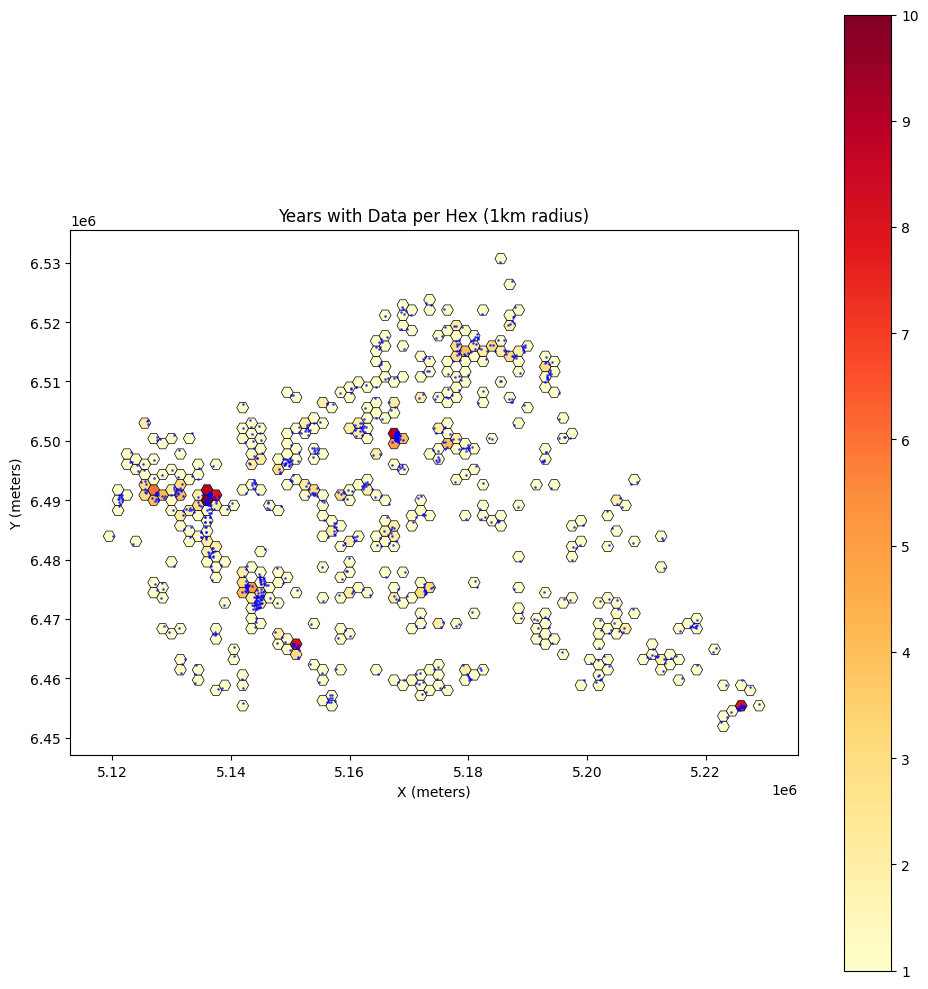

In [5]:
# Plot 1: Years with observations
fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))

hex_with_counts.plot(
    column="years_with_observations",
    cmap="YlOrRd",
    legend=True,
    ax=ax1,
    edgecolor="black",
    linewidth=0.5,
)
grouped_gdf.plot(ax=ax1, color="blue", markersize=1, alpha=0.6)
ax1.set_title("Years with Data per Hex (1km radius)")
ax1.set_xlabel("X (meters)")
ax1.set_ylabel("Y (meters)")

plt.tight_layout()
plt.show()

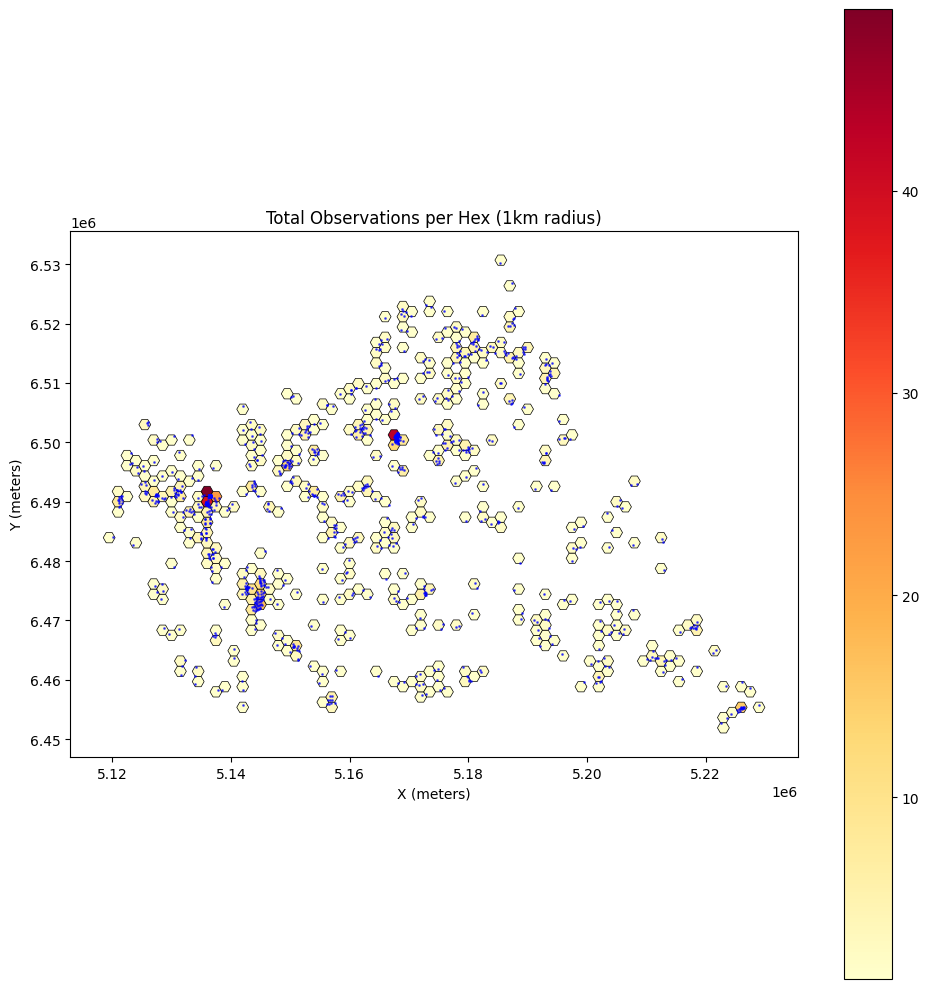

In [6]:
# Plot 2: Total observations
fig, ax2 = plt.subplots(1, 1, figsize=(10, 10))

hex_with_total_obs.plot(
    column="total_observations",
    cmap="YlOrRd",
    legend=True,
    ax=ax2,
    edgecolor="black",
    linewidth=0.5,
)
grouped_gdf.plot(ax=ax2, color="blue", markersize=1, alpha=0.6)
ax2.set_title("Total Observations per Hex (1km radius)")
ax2.set_xlabel("X (meters)")
ax2.set_ylabel("Y (meters)")

plt.tight_layout()
plt.show()

In [26]:
hex_with_counts.to_parquet(
    "/home/nissim/Documents/dev/fulbright/ciut-riesgo/data/villa_del_rosario/datos/hex_grid_annual_counts_1km.parquet"
)

array([[<Axes: title={'center': 'years_with_observations'}>]],
      dtype=object)

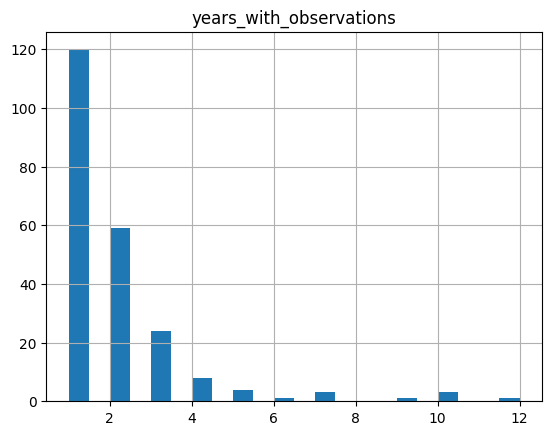

In [18]:
hex_with_counts.hist("years_with_observations", bins=22)

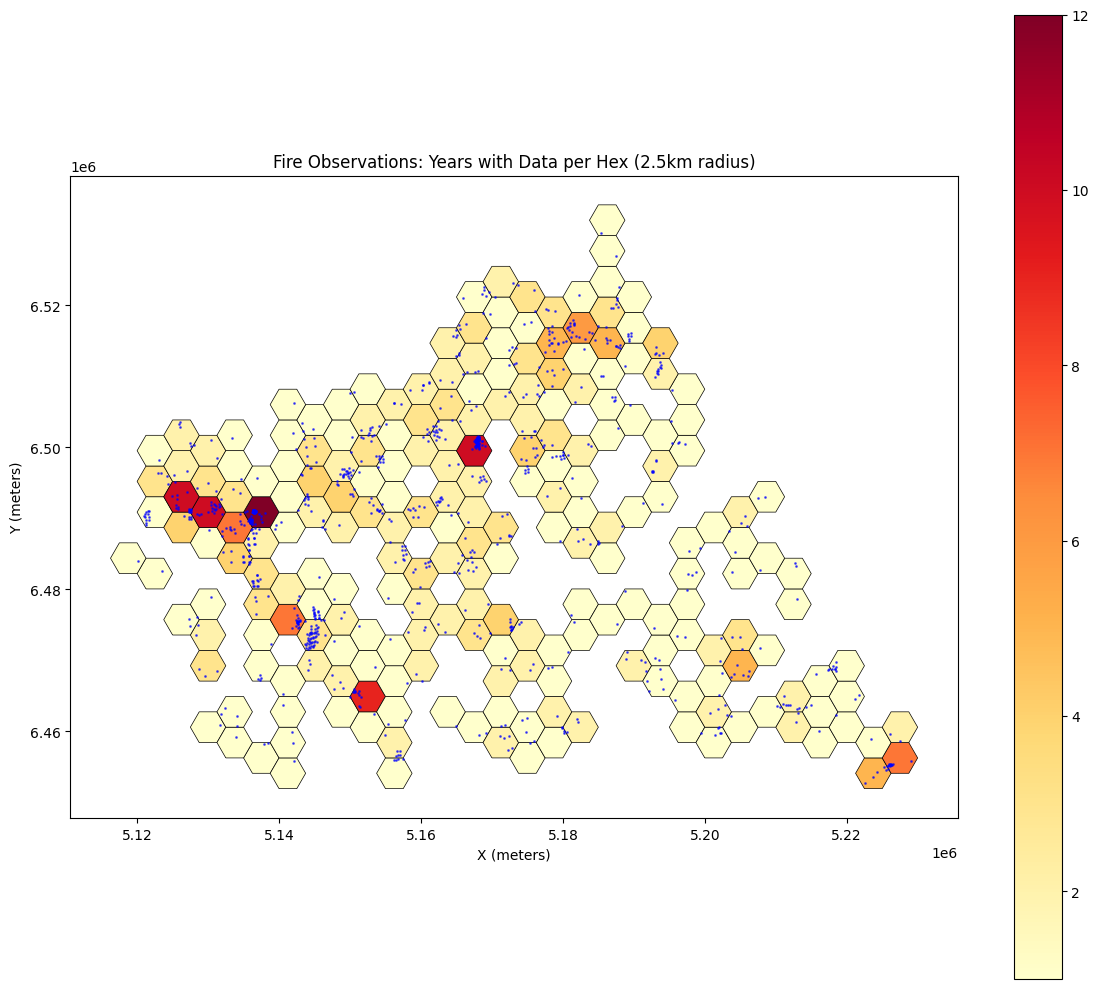

Results saved to 'fire_observations_hex_grid.geojson'


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot hexes colored by number of years with observations
hex_with_counts.plot(
    column="years_with_observations",
    cmap="YlOrRd",
    legend=True,
    ax=ax,
    edgecolor="black",
    linewidth=0.5,
)

# Plot the original points
grouped_gdf.plot(ax=ax, color="blue", markersize=1, alpha=0.6)

ax.set_title("Fire Observations: Years with Data per Hex (2.5km radius)")
ax.set_xlabel("X (meters)")
ax.set_ylabel("Y (meters)")

plt.tight_layout()
plt.show()

In [ ]:
# Combine both dataframes
combined = pd.concat(
    [modis_gdf[["geometry"]], viirs_gdf[["geometry"]]], ignore_index=True
)


# Round coordinates to ~100m precision (0.001 degrees ≈ 100m)
def round_geometry(geom):
    return Point(round(geom.x, 2), round(geom.y, 2))


combined["rounded_geom"] = combined["geometry"].apply(round_geometry)

# Remove duplicates based on rounded geometry
unique_points = combined.drop_duplicates(subset=["rounded_geom"]).drop(
    columns=["rounded_geom"]
)

print(f"Original points: {len(modis_gdf) + len(viirs_gdf)}")
print(f"Unique points: {len(unique_points)}")

Original points: 187
Unique points: 92


In [ ]:
# unique_points.to_parquet("/home/nissim/Documents/dev/fulbright/ciut-riesgo/data/villa_del_rosario/unique_points.parquet")

In [ ]:
# Read in unique points and create 1km buffers
# Ensure all data has the same CRS (USE_CRS = "EPSG:5347")
# Calculate population statistics within the unioned buffer


# 1. Read in unique points (if not already in memory)
# unique_points = gpd.read_parquet("/home/nissim/Documents/dev/fulbright/ciut-riesgo/data/villa_del_rosario/datos/unique_points.parquet")

# 2. Ensure unique_points has the correct CRS
if unique_points.crs != USE_CRS:
    unique_points = unique_points.to_crs(USE_CRS)

# 3. Create 1km buffers around each point
print(f"Creating 1km buffers around {len(unique_points)} unique points...")
unique_points["buffer_1km"] = unique_points.geometry.buffer(2000)  # 1000 meters = 1km

# 4. Union all buffers into a single geometry
print("Creating union of all buffers...")
unioned_buffer = gpd.GeoDataFrame(
    geometry=[unary_union(unique_points["buffer_1km"].values)], crs=USE_CRS
)

# 5. Ensure population rasters have the same CRS as the unioned buffer
print("Ensuring CRS consistency...")
if pob_redistribuida_da.rio.crs != USE_CRS:
    pob_redistribuida_da = pob_redistribuida_da.rio.reproject(USE_CRS)

if pob_privacion_da.rio.crs != USE_CRS:
    pob_privacion_da = pob_privacion_da.rio.reproject(USE_CRS)

# 6. Calculate population statistics within the unioned buffer
print("Calculating population statistics within unioned buffer...")

# Use rasterstats to calculate zonal statistics
from rasterstats import zonal_stats

# Convert unioned buffer to a format that rasterstats can use
buffer_geom = unioned_buffer.geometry.iloc[0]

# Calculate total population within buffer
pop_stats = zonal_stats(
    buffer_geom,
    pob_redistribuida_da.values,
    affine=pob_redistribuida_da.rio.transform(),
    stats=["sum", "count"],
    nodata=0,
)

# Calculate population in poverty within buffer
poverty_stats = zonal_stats(
    buffer_geom,
    pob_privacion_da.values,
    affine=pob_privacion_da.rio.transform(),
    stats=["sum", "count"],
    nodata=0,
)

# 7. Report results
print("\n" + "=" * 50)
print("POPULATION ANALYSIS WITHIN 1KM FIRE BUFFERS")
print("=" * 50)
print(f"Number of unique fire points: {len(unique_points)}")
print("Buffer radius: 1 km")
print(f"Coordinate Reference System: {USE_CRS}")
print(f"Total population within unioned buffer: {pop_stats[0]['sum']:.0f}")
print(f"Population in poverty within unioned buffer: {poverty_stats[0]['sum']:.0f}")

if pop_stats[0]["sum"] > 0:
    poverty_rate = (poverty_stats[0]["sum"] / pop_stats[0]["sum"]) * 100
    print(f"Poverty rate within buffer: {poverty_rate:.2f}%")
else:
    print("No population found within the buffer area")

Creating 1km buffers around 92 unique points...
Creating union of all buffers...
Ensuring CRS consistency...
Calculating population statistics within unioned buffer...

POPULATION ANALYSIS WITHIN 1KM FIRE BUFFERS
Number of unique fire points: 92
Buffer radius: 1 km
Coordinate Reference System: EPSG:5347
Total population within unioned buffer: 18882
Population in poverty within unioned buffer: 5245
Poverty rate within buffer: 27.78%


In [59]:
18882 / total_redistribuido

np.float64(0.9553250713214301)

<Axes: >

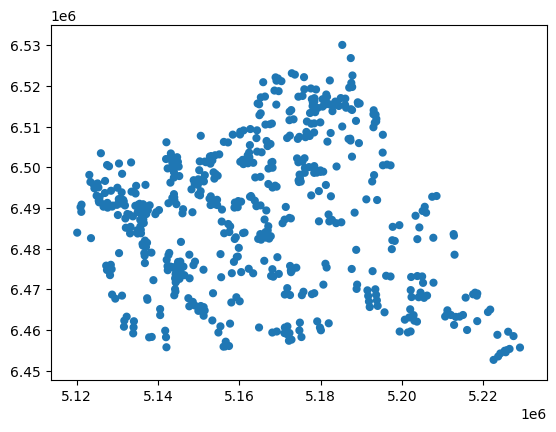

In [29]:
unioned_buffer.plot()

In [30]:
unioned_buffer.to_parquet(
    "/home/nissim/Documents/dev/fulbright/ciut-riesgo/data/villa_del_rosario/datos/unioned_buffer_1km.parquet"
)

np.float64(0.5814747719447617)

In [ ]:
# read in unique points
# buffer 1km around them
# union the buffers
# ensure population (pob_redistribuida_da), pop in poverty (pob_privacion_da) rasters and the unioned buffer have the same CRS
# calculate the pop, pop in poverty within the unioned buffer
# report

# unique_points.to_parquet("/home/nissim/Documents/dev/fulbright/ciut-riesgo/data/villa_del_rosario/unique_points.parquet")

In [ ]:
print(modis_gdf.head())

                    geometry    acq_date  acq_time  bright_t31  brightness  \
0   POINT (-62.9187 -32.019)  2000-11-14      1439  295.600006  308.200012   
1  POINT (-63.6187 -31.5323)  2001-07-28      1433  273.799988  307.299988   
2  POINT (-63.6081 -31.5338)  2001-07-28      1433  277.100006  303.100006   
3  POINT (-63.6317 -31.5596)  2002-07-12      1811  296.100006  307.200012   
4  POINT (-63.6423 -31.5612)  2002-07-12      1811  299.700012  366.799988   

   confidence daynight         frp instrument satellite  scan  track  type  \
0          49        D    4.800000      MODIS     Terra   1.0    1.0     0   
1          49        D   10.400000      MODIS     Terra   1.0    1.0     0   
2          55        D    7.800000      MODIS     Terra   1.0    1.0     0   
3          32        D    4.200000      MODIS      Aqua   1.0    1.0     0   
4         100        D  104.300003      MODIS      Aqua   1.0    1.0     0   

   version  
0      6.2  
1      6.2  
2      6.2  
3      6.2

In [ ]:
print(viirs_gdf.head())

                      geometry    acq_date  acq_time  bright_ti4  bright_ti5  \
0  POINT (-63.36078 -31.46117)  2012-10-24      1847  367.000000  293.230011   
1  POINT (-63.84928 -31.62288)  2012-07-25      1854  367.000000  293.890015   
2  POINT (-63.83323 -31.66405)  2012-06-27       515  301.040009  283.869995   
3  POINT (-63.83244 -31.66419)  2012-05-10       516  300.690002  286.739990   
4  POINT (-63.83203 -31.66506)  2012-07-18       522  297.760010  277.149994   

  confidence daynight    frp instrument satellite  scan  track  type  version  
0          h        D  20.32      VIIRS         N  0.45   0.63     0        1  
1          h        D  28.65      VIIRS         N  0.52   0.67     0        1  
2          n        N   0.61      VIIRS         N  0.38   0.36     0        1  
3          n        N   0.61      VIIRS         N  0.38   0.36     0        1  
4          n        N   0.83      VIIRS         N  0.39   0.36     0        1  


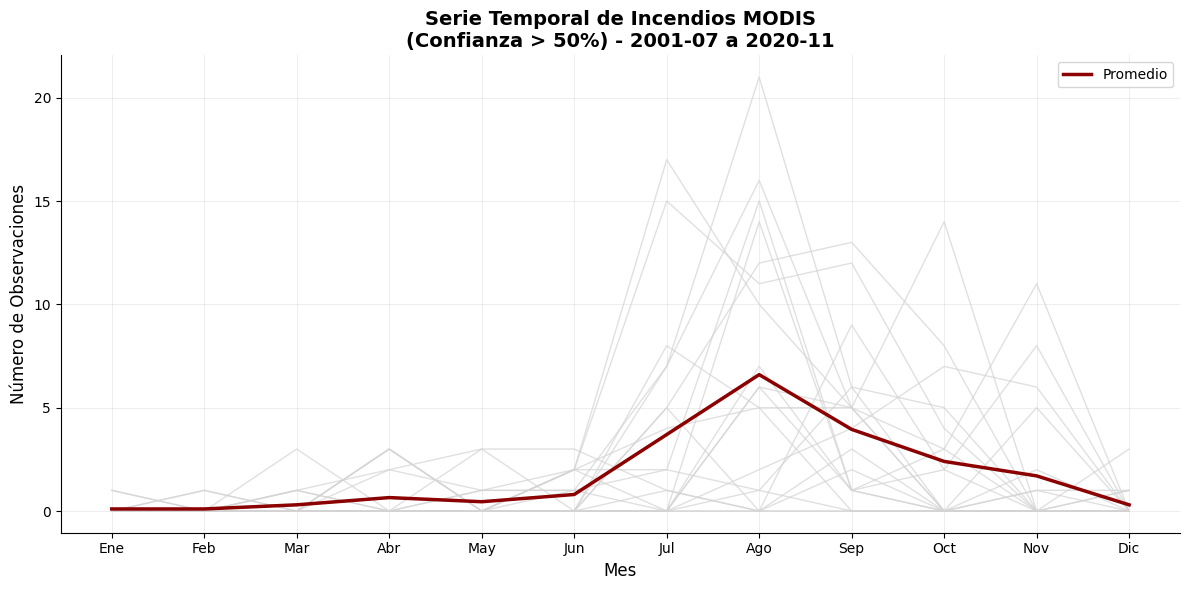

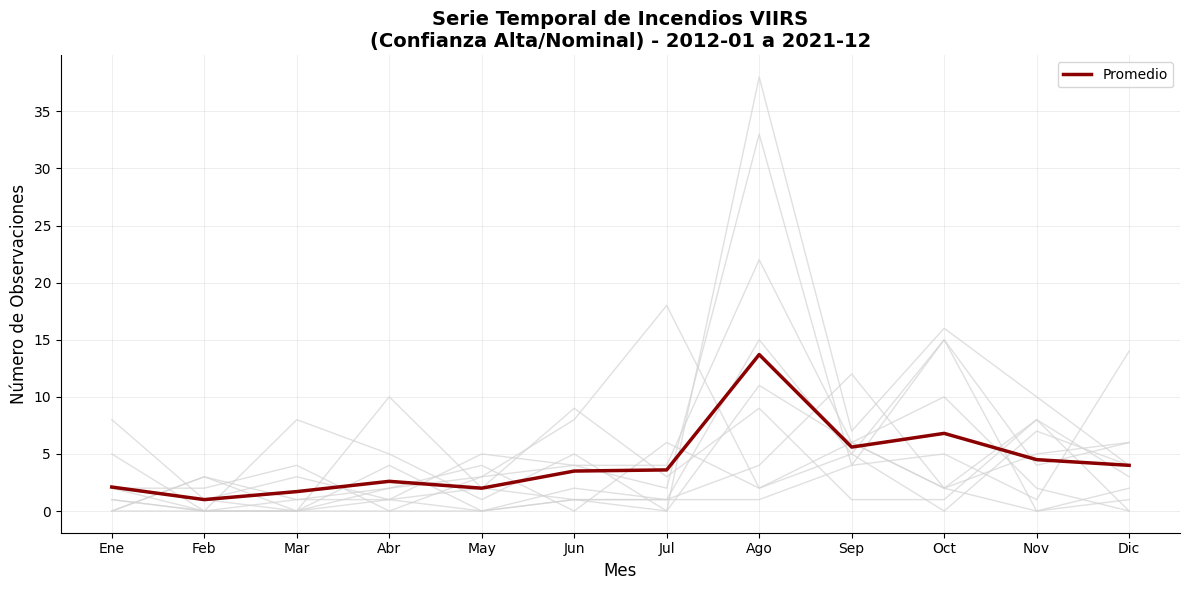

In [ ]:
# MODIS - Filter for confidence > 50
modis_filtered = modis_gdf[modis_gdf["confidence"] > 50].copy()
modis_filtered["acq_date"] = pd.to_datetime(modis_filtered["acq_date"])
modis_filtered["year"] = modis_filtered["acq_date"].dt.year
modis_filtered["month"] = modis_filtered["acq_date"].dt.month

# Get date range for MODIS
modis_start = modis_filtered["acq_date"].min().strftime("%Y-%m")
modis_end = modis_filtered["acq_date"].max().strftime("%Y-%m")

# Count observations per month per year
modis_monthly_counts = (
    modis_filtered.groupby(["year", "month"]).size().reset_index(name="count")
)

# Create complete year-month combinations and fill missing months with 0
modis_years = sorted(modis_filtered["year"].unique())
modis_complete_data = []
for year in modis_years:
    for month in range(1, 13):
        existing = modis_monthly_counts[
            (modis_monthly_counts["year"] == year)
            & (modis_monthly_counts["month"] == month)
        ]
        count = existing["count"].iloc[0] if len(existing) > 0 else 0
        modis_complete_data.append({"year": year, "month": month, "count": count})

modis_complete_df = pd.DataFrame(modis_complete_data)

# Calculate average across all years for each month
modis_monthly_avg = modis_complete_df.groupby("month")["count"].mean().reset_index()

# Create MODIS plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot individual years in grey
for year in modis_years:
    year_data = modis_complete_df[modis_complete_df["year"] == year]
    ax.plot(
        year_data["month"],
        year_data["count"],
        color="lightgrey",
        alpha=0.7,
        linewidth=1,
    )

# Plot average line in dark red
ax.plot(
    modis_monthly_avg["month"],
    modis_monthly_avg["count"],
    color="darkred",
    linewidth=2.5,
    label="Promedio",
)

# Customize the plot
ax.set_xlabel("Mes", fontsize=12)
ax.set_ylabel("Número de Observaciones", fontsize=12)
ax.set_title(
    f"Serie Temporal de Incendios MODIS\n(Confianza > 50%) - {modis_start} a {modis_end}",
    fontsize=14,
    fontweight="bold",
)

# Set month labels
month_names = [
    "Ene",
    "Feb",
    "Mar",
    "Abr",
    "May",
    "Jun",
    "Jul",
    "Ago",
    "Sep",
    "Oct",
    "Nov",
    "Dic",
]
ax.set_xticks(range(1, 13))
ax.set_xticklabels(month_names)

# Add legend
ax.legend(loc="upper right")

# Remove top and right spines for minimalist look
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Set grid
ax.grid(True, alpha=0.3, linestyle="-", linewidth=0.5)

plt.tight_layout()
plt.show()

# VIIRS - Filter for confidence = 'h' or 'n'
viirs_filtered = viirs_gdf[viirs_gdf["confidence"].isin(["h", "n"])].copy()
viirs_filtered["acq_date"] = pd.to_datetime(viirs_filtered["acq_date"])
viirs_filtered["year"] = viirs_filtered["acq_date"].dt.year
viirs_filtered["month"] = viirs_filtered["acq_date"].dt.month

# Get date range for VIIRS
viirs_start = viirs_filtered["acq_date"].min().strftime("%Y-%m")
viirs_end = viirs_filtered["acq_date"].max().strftime("%Y-%m")

# Count observations per month per year
viirs_monthly_counts = (
    viirs_filtered.groupby(["year", "month"]).size().reset_index(name="count")
)

# Create complete year-month combinations and fill missing months with 0
viirs_years = sorted(viirs_filtered["year"].unique())
viirs_complete_data = []
for year in viirs_years:
    for month in range(1, 13):
        existing = viirs_monthly_counts[
            (viirs_monthly_counts["year"] == year)
            & (viirs_monthly_counts["month"] == month)
        ]
        count = existing["count"].iloc[0] if len(existing) > 0 else 0
        viirs_complete_data.append({"year": year, "month": month, "count": count})

viirs_complete_df = pd.DataFrame(viirs_complete_data)

# Calculate average across all years for each month
viirs_monthly_avg = viirs_complete_df.groupby("month")["count"].mean().reset_index()

# Create VIIRS plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot individual years in grey
for year in viirs_years:
    year_data = viirs_complete_df[viirs_complete_df["year"] == year]
    ax.plot(
        year_data["month"],
        year_data["count"],
        color="lightgrey",
        alpha=0.7,
        linewidth=1,
    )

# Plot average line in dark red
ax.plot(
    viirs_monthly_avg["month"],
    viirs_monthly_avg["count"],
    color="darkred",
    linewidth=2.5,
    label="Promedio",
)

# Customize the plot
ax.set_xlabel("Mes", fontsize=12)
ax.set_ylabel("Número de Observaciones", fontsize=12)
ax.set_title(
    f"Serie Temporal de Incendios VIIRS\n(Confianza Alta/Nominal) - {viirs_start} a {viirs_end}",
    fontsize=14,
    fontweight="bold",
)

# Set month labels
month_names = [
    "Ene",
    "Feb",
    "Mar",
    "Abr",
    "May",
    "Jun",
    "Jul",
    "Ago",
    "Sep",
    "Oct",
    "Nov",
    "Dic",
]
ax.set_xticks(range(1, 13))
ax.set_xticklabels(month_names)

# Add legend
ax.legend(loc="upper right")

# Remove top and right spines for minimalist look
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Set grid
ax.grid(True, alpha=0.3, linestyle="-", linewidth=0.5)

plt.tight_layout()
plt.show()

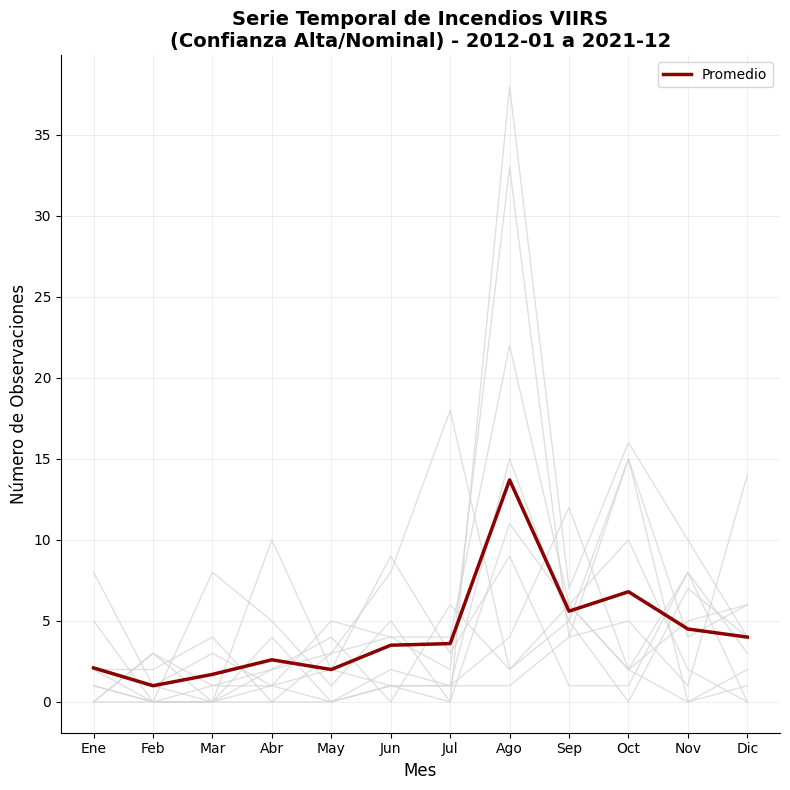

In [14]:
# VIIRS - Filter for confidence = 'h' or 'n'
viirs_filtered = viirs_gdf[viirs_gdf["confidence"].isin(["h", "n"])].copy()
viirs_filtered["acq_date"] = pd.to_datetime(viirs_filtered["acq_date"])
viirs_filtered["year"] = viirs_filtered["acq_date"].dt.year
viirs_filtered["month"] = viirs_filtered["acq_date"].dt.month

# Get date range for VIIRS
viirs_start = viirs_filtered["acq_date"].min().strftime("%Y-%m")
viirs_end = viirs_filtered["acq_date"].max().strftime("%Y-%m")

# Count observations per month per year
viirs_monthly_counts = (
    viirs_filtered.groupby(["year", "month"]).size().reset_index(name="count")
)

# Create complete year-month combinations and fill missing months with 0
viirs_years = sorted(viirs_filtered["year"].unique())
viirs_complete_data = []
for year in viirs_years:
    for month in range(1, 13):
        existing = viirs_monthly_counts[
            (viirs_monthly_counts["year"] == year)
            & (viirs_monthly_counts["month"] == month)
        ]
        count = existing["count"].iloc[0] if len(existing) > 0 else 0
        viirs_complete_data.append({"year": year, "month": month, "count": count})

viirs_complete_df = pd.DataFrame(viirs_complete_data)

# Calculate average across all years for each month
viirs_monthly_avg = viirs_complete_df.groupby("month")["count"].mean().reset_index()

# Create VIIRS plot with 1:1 aspect ratio
fig, ax = plt.subplots(figsize=(8, 8))

# Plot individual years in grey
for year in viirs_years:
    year_data = viirs_complete_df[viirs_complete_df["year"] == year]
    ax.plot(
        year_data["month"],
        year_data["count"],
        color="lightgrey",
        alpha=0.7,
        linewidth=1,
    )

# Plot average line in dark red
ax.plot(
    viirs_monthly_avg["month"],
    viirs_monthly_avg["count"],
    color="darkred",
    linewidth=2.5,
    label="Promedio",
)

# Customize the plot
ax.set_xlabel("Mes", fontsize=12)
ax.set_ylabel("Número de Observaciones", fontsize=12)
ax.set_title(
    f"Serie Temporal de Incendios VIIRS\n(Confianza Alta/Nominal) - {viirs_start} a {viirs_end}",
    fontsize=14,
    fontweight="bold",
)

# Set month labels
month_names = [
    "Ene",
    "Feb",
    "Mar",
    "Abr",
    "May",
    "Jun",
    "Jul",
    "Ago",
    "Sep",
    "Oct",
    "Nov",
    "Dic",
]
ax.set_xticks(range(1, 13))
ax.set_xticklabels(month_names)

# Add legend
ax.legend(loc="upper right")

# Remove top and right spines for minimalist look
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Set grid
ax.grid(True, alpha=0.3, linestyle="-", linewidth=0.5)

plt.tight_layout()

# Save as SVG with 300 DPI
plt.savefig(
    "/home/nissim/Documents/dev/fulbright/ciut-riesgo/data/villa_del_rosario/VIIRS_temporal_series.svg",
    format="svg",
    dpi=300,
    bbox_inches="tight",
)

plt.show()

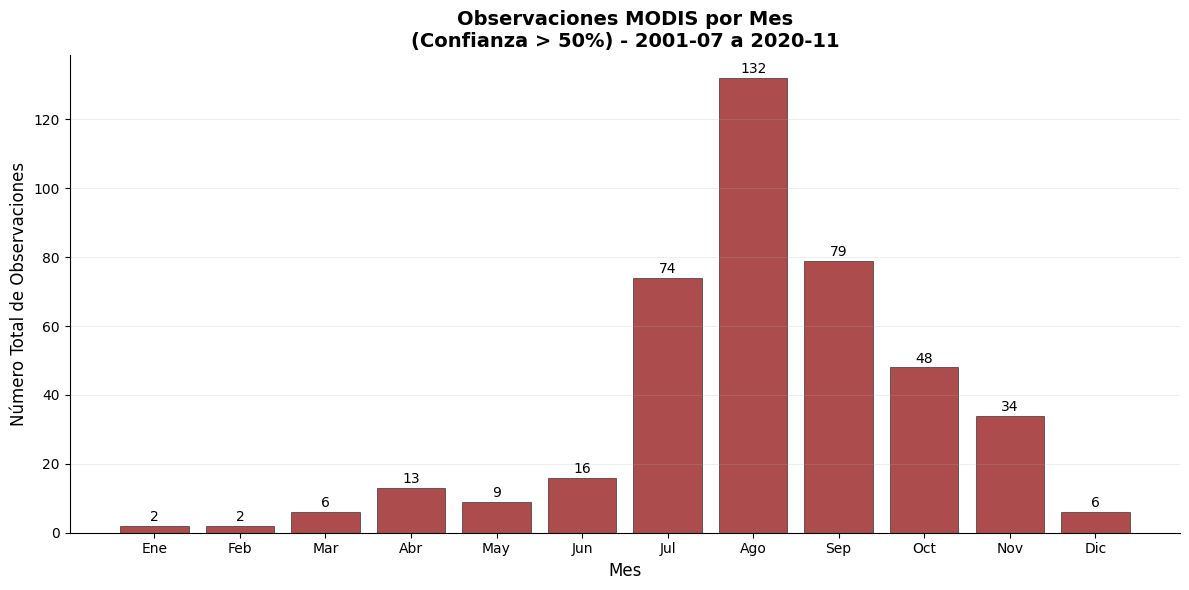

In [19]:
# Create bar chart of MODIS observations per month
fig, ax = plt.subplots(figsize=(12, 6))

# Calculate total observations per month across all years
monthly_totals = modis_filtered.groupby("month").size()

# Create bar chart
bars = ax.bar(
    monthly_totals.index,
    monthly_totals.values,
    color="darkred",
    alpha=0.7,
    edgecolor="black",
    linewidth=0.5,
)

# Customize the plot
ax.set_xlabel("Mes", fontsize=12)
ax.set_ylabel("Número Total de Observaciones", fontsize=12)
ax.set_title(
    f"Observaciones MODIS por Mes\n(Confianza > 50%) - {modis_start} a {modis_end}",
    fontsize=14,
    fontweight="bold",
)

# Set month labels
month_names = [
    "Ene",
    "Feb",
    "Mar",
    "Abr",
    "May",
    "Jun",
    "Jul",
    "Ago",
    "Sep",
    "Oct",
    "Nov",
    "Dic",
]
ax.set_xticks(range(1, 13))
ax.set_xticklabels(month_names)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + 0.5,
        f"{int(height)}",
        ha="center",
        va="bottom",
        fontsize=10,
    )

# Remove top and right spines for minimalist look
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Set grid
ax.grid(True, alpha=0.3, linestyle="-", linewidth=0.5, axis="y")

plt.tight_layout()
plt.show()

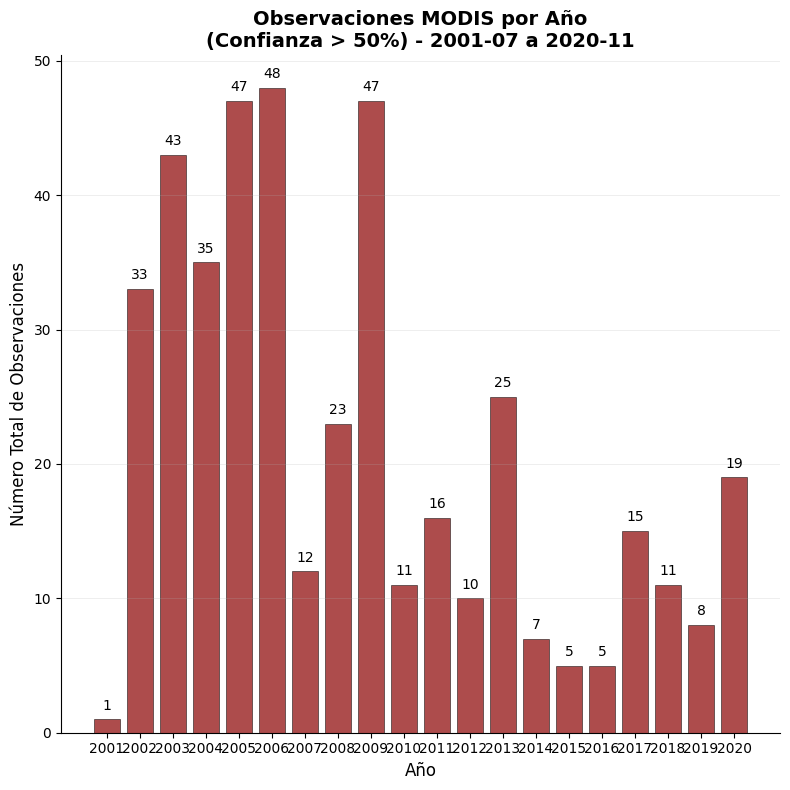

In [23]:
# Create bar chart of MODIS observations per year
fig, ax = plt.subplots(figsize=(8, 8))  # Square figure for 1:1 aspect ratio

# Calculate total observations per year
yearly_totals = modis_filtered.groupby("year").size()

# Create bar chart with integer years
bars = ax.bar(
    range(len(yearly_totals)),
    yearly_totals.values,
    color="darkred",
    alpha=0.7,
    edgecolor="black",
    linewidth=0.5,
)

# Customize the plot
ax.set_xlabel("Año", fontsize=12)
ax.set_ylabel("Número Total de Observaciones", fontsize=12)
ax.set_title(
    f"Observaciones MODIS por Año\n(Confianza > 50%) - {modis_start} a {modis_end}",
    fontsize=14,
    fontweight="bold",
)

# Set year labels as integers
ax.set_xticks(range(len(yearly_totals)))
ax.set_xticklabels(yearly_totals.index.astype(int))

# Add value labels on top of bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + 0.5,
        f"{int(height)}",
        ha="center",
        va="bottom",
        fontsize=10,
    )

# Remove top and right spines for minimalist look
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Set grid
ax.grid(True, alpha=0.3, linestyle="-", linewidth=0.5, axis="y")

plt.tight_layout()

# Save as SVG with 300 DPI
plt.savefig(
    "/home/nissim/Documents/dev/fulbright/ciut-riesgo/data/villa_del_rosario/mODIS_observations_per_year.svg",
    format="svg",
    dpi=300,
    bbox_inches="tight",
)

plt.show()

In [ ]:
# export as a dataframe with dates and times for the observations
# make a time series plot of observations per month per year
# add an average line to show typical burn months

# then, figure out how to spatially visualize this based on the resolution of each dataset--375m? 750m?
# how do I add in other stuff, e.g., from IDECOR? other resolutions?

In [ ]:
def create_fire_mask(gdf, resolution_m, crs="EPSG:4326"):
    """
    Create a binary mask from fire observations at specified resolution

    Parameters:
    gdf: GeoDataFrame with fire observations
    resolution_m: Resolution in meters
    crs: Coordinate reference system
    """
    # Get bounds of the data
    bounds = gdf.total_bounds

    # Convert resolution from meters to degrees (approximate)
    # 1 degree ≈ 111,000 meters at the equator
    resolution_deg = resolution_m / 111000

    # Create coordinate arrays
    lon_min, lat_min, lon_max, lat_max = bounds
    lons = np.arange(lon_min, lon_max + resolution_deg, resolution_deg)
    lats = np.arange(lat_min, lat_max + resolution_deg, resolution_deg)

    # Create empty mask
    mask = np.zeros((len(lats), len(lons)), dtype=np.uint8)

    # Create grid points
    lon_grid, lat_grid = np.meshgrid(lons, lats)

    # For each fire observation, find the corresponding grid cell
    for idx, row in gdf.iterrows():
        lon, lat = row.geometry.x, row.geometry.y

        # Find closest grid cell
        lon_idx = np.argmin(np.abs(lons - lon))
        lat_idx = np.argmin(np.abs(lats - lat))

        # Set mask to 1 for this cell
        mask[lat_idx, lon_idx] = 1

    # Create xarray DataArray with correct dimension names
    da = xr.DataArray(
        mask,
        coords={
            "y": lats,  # Use 'y' instead of 'lat'
            "x": lons,  # Use 'x' instead of 'lon'
        },
        dims=["y", "x"],  # Use 'y', 'x' instead of 'lat', 'lon'
        name="fire_mask",
    )

    # Add CRS information
    da = da.rio.write_crs(crs)

    return da


# Create MODIS mask at 1km resolution (1000m)
modis_mask = create_fire_mask(modis_gdf, resolution_m=1000)

# Create VIIRS mask at 375m resolution
viirs_mask = create_fire_mask(viirs_gdf, resolution_m=375)

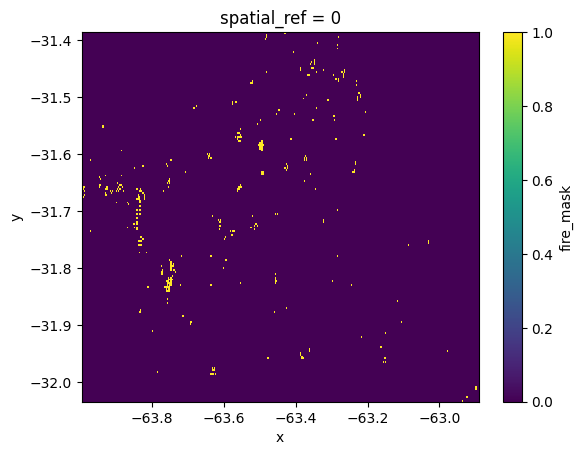

In [36]:
viirs_mask.plot()

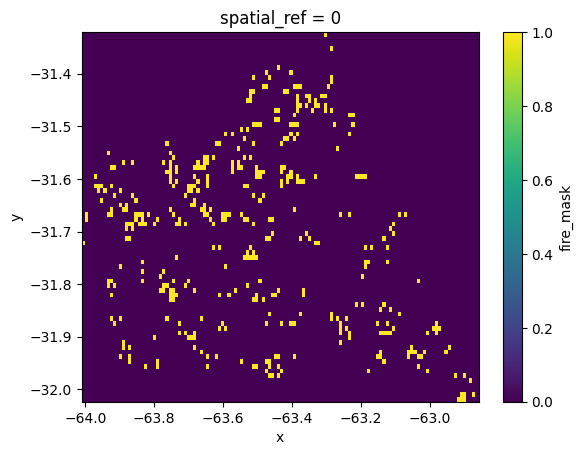

In [37]:
modis_mask.plot()

In [38]:
modis_mask.rio.to_raster(
    "/home/nissim/Documents/dev/fulbright/ciut-riesgo/data/villa_del_rosario/modis_fire_mask_1km.tif"
)
viirs_mask.rio.to_raster(
    "/home/nissim/Documents/dev/fulbright/ciut-riesgo/data/villa_del_rosario/viirs_fire_mask_375m.tif"
)

## Incendios

In [ ]:
URL = "https://cmr.earthdata.nasa.gov/stac/LANCEMODIS"

catalog = Client.open(URL)

catalog.get_collection("MYD14_6.1NRT")

In [ ]:
def intersection_percent(item: Item, aoi_geometry) -> float:
    """The percentage that the Item's geometry intersects the AOI geometry."""
    geom_item = shape(item.geometry)
    geom_aoi = aoi_geometry  # Already a geometry object

    intersected_geom = geom_aoi.intersection(geom_item)
    intersection_percent = (intersected_geom.area * 100) / geom_aoi.area

    return intersection_percent


# Extract the geometry once and reuse it
aoi_geometry = aoi.to_crs(4326).geometry.iloc[0]

item_search = catalog.search(
    collections=["MYD14_6.1NRT"], intersects=aoi_geometry, max_items=10
)

print(
    [f"{intersection_percent(item, aoi_geometry):.2f}" for item in item_search.items()]
)

In [ ]:
# Create a Client and an ItemSearch representing our search
# No search operations will be performed until we call the items() method
client = Client.open(URL)
item_search = client.search(collections=["MYD14_6.1NRT"], intersects=aoi, max_items=10)

In [ ]:
catalog = Client.open("https://cmr.earthdata.nasa.gov/stac")

for link in catalog.links:
    print(link.href)

In [ ]:
# Search NASA's Earthdata for VIIRS collections
search_url = "https://cmr.earthdata.nasa.gov/search/collections.json"
params = {"keyword": "VIIRS fire", "page_size": 20}

response = requests.get(search_url, params=params)
if response.status_code == 200:
    data = response.json()
    print("VIIRS collections available through Earthdata:")
    for entry in data.get("feed", {}).get("entry", []):
        print(f"  {entry.get('title')}: {entry.get('id')}")
        print(f"    Provider: {entry.get('provider')}")
        print(f"    Short name: {entry.get('short_name')}")
        print("---")

In [ ]:
# Try the LPCLOUD STAC endpoint directly
try:
    lpcloud_catalog = Client.open("https://cmr.earthdata.nasa.gov/stac/LPCLOUD")

    print("LPCLOUD collections:")
    for link in lpcloud_catalog.links:
        if link.rel == "child":
            print(f"  {link.title}: {link.href}")

    # Try to access VNP14A1 collection
    vnp14a1_collection = Client.open(
        "https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/VNP14A1"
    )

    # Search for items
    aoi_geometry = aoi.to_crs(4326).geometry.iloc[0]
    item_search = vnp14a1_collection.search(intersects=aoi_geometry, max_items=10)

    for item in item_search.items():
        print(f"VIIRS item: {item.id}")

except Exception as e:
    print(f"Error: {e}")

In [ ]:
# Try using the collection concept ID
collection_id = "C2545314541-LPCLOUD"

try:
    # Try different STAC endpoints
    endpoints = [
        f"https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/{collection_id}",
        f"https://cmr.earthdata.nasa.gov/stac/ALL/collections/{collection_id}",
        f"https://cmr.earthdata.nasa.gov/stac/collections/{collection_id}",
    ]

    for endpoint in endpoints:
        try:
            collection = Client.open(endpoint)
            print(f"Successfully opened: {endpoint}")
            print(f"Collection: {collection.title}")
            break
        except Exception as e:
            print(f"Failed {endpoint}: {e}")

except Exception as e:
    print(f"Error: {e}")

In [ ]:
def get_collection_info(collection_id):
    """
    Get detailed information about a VIIRS collection
    """
    url = "https://cmr.earthdata.nasa.gov/search/collections.json"
    params = {"concept_id": collection_id}

    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()
        collection = data["feed"]["entry"][0]

        print(f"Collection: {collection['title']}")
        print(f"Short Name: {collection['short_name']}")
        print(f"Description: {collection['summary']}")
        print(f"Provider: {collection.get('provider', 'Unknown')}")
        print(
            f"Temporal Range: {collection.get('time_start')} to {collection.get('time_end')}"
        )

        return collection
    else:
        print(f"Error: {response.status_code}")
        return None


# Get info about VNP14A1
get_collection_info("C2545314541-LPCLOUD")

In [ ]:
# Open LPDAAC catalog and search for the specific collection
lpdaac_catalog = Client.open("https://cmr.earthdata.nasa.gov/stac/LPDAAC_ECS")

# Find the viirs-14a1-001 collection
viirs_link = None
for link in lpdaac_catalog.links:
    if link.rel == "child" and "VNP14A1 v001" in link.href:
        viirs_link = link
        break

if viirs_link:
    print(f"Found VIIRS collection: {viirs_link.title}")
    print(f"URL: {viirs_link.href}")

    # Open the collection and search for items
    viirs_collection = Client.open(viirs_link.href)
    aoi_geometry = aoi.to_crs(4326).geometry.iloc[0]

    item_search = viirs_collection.search(intersects=aoi_geometry, max_items=10)

    for item in item_search.items():
        print(f"VIIRS item: {item.id}")
else:
    print("VIIRS collection not found in ALL")

In [ ]:
item_search

In [ ]:
# Try different potential VIIRS STAC endpoints
potential_endpoints = [
    "https://cmr.earthdata.nasa.gov/stac/LPDAAC",
    "https://cmr.earthdata.nasa.gov/stac/MODIS",
    "https://cmr.earthdata.nasa.gov/stac/VIIRS",
    "https://cmr.earthdata.nasa.gov/stac/FIRE",
]

for endpoint in potential_endpoints:
    try:
        catalog = Client.open(endpoint)
        print(f"Successfully opened: {endpoint}")
        print("Collections available:")
        for link in catalog.links:
            if link.rel == "child":
                print(f"  - {link.title}")
        print("---")
    except Exception as e:
        print(f"Failed to open {endpoint}: {e}")

In [ ]:
catalog = Client.open("https://cmr.earthdata.nasa.gov/stac/USGS")

for link in catalog.links:
    print(link.href)

In [ ]:
URL = "https://cmr.earthdata.nasa.gov/stac/LANCEMODIS"

catalog = Client.open(URL)

catalog.get_collection("MYD14_6.1NRT")

In [ ]:
# Extract the geometry once and reuse it
aoi_geometry = aoi.to_crs(4326).geometry.iloc[0]


def setup_earthdata_auth():
    """
    Set up NASA Earthdata authentication
    You'll need to create an account at https://urs.earthdata.nasa.gov/
    """
    username = input("Enter your NASA Earthdata username: ")
    password = input("Enter your NASA Earthdata password: ")

    # Store credentials (you might want to use environment variables instead)
    os.environ["EARTHDATA_USERNAME"] = username
    os.environ["EARTHDATA_PASSWORD"] = password

    return username, password


def search_viirs_granules(
    collection_id, aoi_geometry, start_date, end_date, max_results=5
):
    """
    Search for VIIRS granules using CMR API
    """
    cmr_url = "https://cmr.earthdata.nasa.gov/search/granules.json"

    bbox = aoi_geometry.bounds

    params = {
        "collection_concept_id": collection_id,
        "bounding_box": f"{bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]}",
        "temporal": f"{start_date}T00:00:00Z,{end_date}T23:59:59Z",
        "page_size": max_results,
        "sort_key": "-start_date",
    }

    response = requests.get(cmr_url, params=params)

    if response.status_code == 200:
        data = response.json()
        granules = data["feed"]["entry"]

        print(f"Found {len(granules)} VIIRS granules:")
        for i, granule in enumerate(granules):
            print(f"  {i + 1}. {granule['title']}")
            print(f"     Time: {granule['time_start']}")
            print(f"     Size: {granule.get('granule_size', 'Unknown')}")

            # Get cloud access URLs
            cloud_urls = []
            for link in granule["links"]:
                if link["rel"] == "http://esipfed.org/ns/fedsearch/1.1/data#":
                    cloud_urls.append(link["href"])

            if cloud_urls:
                print(f"     Cloud URL: {cloud_urls[0]}")
            print("---")

        return granules
    else:
        print(f"Error: {response.status_code} - {response.text}")
        return []


# Usage
collection_id = "C2545314541-LPCLOUD"  # VNP14A1
start_date = "2023-01-01"
end_date = "2025-01-31"

granules = search_viirs_granules(collection_id, aoi_geometry, start_date, end_date)

Found 5 VIIRS granules:
  1. VNP14A1.A2025031.h12v12.002.2025032090653
     Time: 2025-01-31T00:00:00.000Z
     Size: 0.1575489044189453
     Cloud URL: https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/VNP14A1.002/VNP14A1.A2025031.h12v12.002.2025032090653/VNP14A1.A2025031.h12v12.002.2025032090653.h5
---
  2. VNP14A1.A2025030.h12v12.002.2025031094640
     Time: 2025-01-30T00:00:00.000Z
     Size: 0.15435218811035156
     Cloud URL: https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/VNP14A1.002/VNP14A1.A2025030.h12v12.002.2025031094640/VNP14A1.A2025030.h12v12.002.2025031094640.h5
---
  3. VNP14A1.A2025029.h12v12.002.2025030094347
     Time: 2025-01-29T00:00:00.000Z
     Size: 0.1571207046508789
     Cloud URL: https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/VNP14A1.002/VNP14A1.A2025029.h12v12.002.2025030094347/VNP14A1.A2025029.h12v12.002.2025030094347.h5
---
  4. VNP14A1.A2025028.h12v12.002.2025029084239
     Time: 2025-01-28T00:00:00.000Z
     Size:

In [ ]:
# Download the file
username = "nissimlebovits"
password = "KNsna3qk6aPEEvk"

print("Downloading VIIRS file...")
response = requests.get(cloud_url, auth=HTTPBasicAuth(username, password))

if response.status_code == 200:
    with open("temp_viirs.h5", "wb") as f:
        f.write(response.content)

    # Open with h5py
    with h5py.File("temp_viirs.h5", "r") as f:
        fire_mask = f["HDFEOS/GRIDS/VNP_Grid_1km_2D/Data Fields/FireMask"][:]

    plt.imshow(fire_mask)
    plt.title("VIIRS Fire Mask")
    plt.show()

    # Clean up
    import os

    os.remove("temp_viirs.h5")
else:
    print(f"Download failed: {response.status_code}")

Download failed: 401


In [ ]:
auth = earthaccess.login()

In [ ]:
# Extract individual bounding box values
bbox = aoi.to_crs(4326).bounds.iloc[0]
minx, miny, maxx, maxy = bbox

# Search for VIIRS data
viirs_data = earthaccess.search_data(
    short_name="VNP14A1",
    bounding_box=(minx, miny, maxx, maxy),  # Pass as tuple
    cloud_hosted=True,
    temporal=("2001-01", "2021-01"),
)

print(f"Found {len(viirs_data)} granules")

# First, get the coordinate system and find exact pixel bounds for your AOI
files = earthaccess.open([viirs_data[0]], show_progress=False)
file_path = files[0]

with h5py.File(file_path, "r") as f:
    xdim = f["HDFEOS/GRIDS/VIIRS_Grid_Daily_Fire/XDim"][:]
    ydim = f["HDFEOS/GRIDS/VIIRS_Grid_Daily_Fire/YDim"][:]

# Transform AOI to sinusoidal projection
aoi_sinusoidal = aoi.to_crs("EPSG:4326").to_crs(
    "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"
)
aoi_bounds = aoi_sinusoidal.bounds.iloc[0]

# Find exact pixel indices for your AOI
x_indices = np.where((xdim >= aoi_bounds.iloc[0]) & (xdim <= aoi_bounds.iloc[2]))[0]
y_indices = np.where((ydim >= aoi_bounds.iloc[1]) & (ydim <= aoi_bounds.iloc[3]))[0]

print(
    f"Cropping to {len(y_indices)} x {len(x_indices)} pixels instead of full {len(ydim)} x {len(xdim)}"
)

Found 3300 granules


In [55]:
# # Let's check what file sizes we actually have
# file_sizes = [granule.get('Size(MB)', 0) for granule in viirs_data]
# print(f"File size range: {min(file_sizes):.3f} - {max(file_sizes):.3f} MB")
# print(f"Average file size: {np.mean(file_sizes):.3f} MB")

# # Check the distribution
# import matplotlib.pyplot as plt
# plt.hist(file_sizes, bins=50)
# plt.xlabel('File Size (MB)')
# plt.ylabel('Count')
# plt.title('Distribution of VIIRS File Sizes')
# plt.show()

# # Let's actually check a few files manually to see what's in them
# print("Manually checking first 5 files...")
# for i, granule in enumerate(viirs_data[:5]):
#     print(f"\nFile {i+1}:")
#     print(f"Size: {granule.get('Size(MB)', 0):.3f} MB")

#     try:
#         files = earthaccess.open([granule], show_progress=False)
#         file_path = files[0]

#         with h5py.File(file_path, 'r') as f:
#             fire_mask = f['HDFEOS/GRIDS/VIIRS_Grid_Daily_Fire/Data Fields/FireMask'][:]
#             print(f"FireMask shape: {fire_mask.shape}")
#             print(f"FireMask unique values: {np.unique(fire_mask)}")
#             print(f"Fire pixels (>=7): {np.sum(fire_mask >= 7)}")

#             # Check if our AOI area has any fire
#             if len(y_indices) > 0 and len(x_indices) > 0:
#                 aoi_fire_mask = fire_mask[y_indices, :][:, x_indices]
#                 print(f"AOI fire pixels: {np.sum(aoi_fire_mask >= 7)}")

#     except Exception as e:
#         print(f"Error: {e}")

In [54]:
# # Process in batches to avoid memory issues
# batch_size = 100
# fire_counts = []

# for i in range(0, len(viirs_data), batch_size):
#     batch = viirs_data[i:i+batch_size]
#     print(f"Processing batch {i//batch_size + 1}/{(len(viirs_data)-1)//batch_size + 1}")

#     # Your existing efficient processing
#     lazy_arrays = [process_granule_cropped(granule) for granule in batch]
#     fire_stack = da.stack([da.from_delayed(arr, dtype=np.int8, shape=(len(y_indices), len(x_indices)))
#                           for arr in lazy_arrays if arr is not None])
#     fire_count_batch = da.sum(fire_stack, axis=0)

#     with ProgressBar():
#         fire_counts.append(fire_count_batch.compute())

# # Sum all batches
# final_fire_count = np.sum(fire_counts, axis=0)

In [53]:
# # Let's check what's happening with the AOI cropping
# print("AOI Debugging:")
# print(f"AOI bounds (sinusoidal): {aoi_bounds}")
# print(f"X indices range: {x_indices.min()} to {x_indices.max()}")
# print(f"Y indices range: {y_indices.min()} to {y_indices.max()}")
# print(f"AOI size: {len(y_indices)} x {len(x_indices)} pixels")

# # Let's see where the fires actually are
# print("\nChecking fire locations in first file...")
# files = earthaccess.open([viirs_data[0]], show_progress=False)
# file_path = files[0]

# with h5py.File(file_path, 'r') as f:
#     fire_mask = f['HDFEOS/GRIDS/VIIRS_Grid_Daily_Fire/Data Fields/FireMask'][:]
#     xdim = f['HDFEOS/GRIDS/VIIRS_Grid_Daily_Fire/XDim'][:]
#     ydim = f['HDFEOS/GRIDS/VIIRS_Grid_Daily_Fire/YDim'][:]

#     # Find where the fires are
#     fire_locations = np.where(fire_mask >= 7)
#     print(f"Fire locations (y, x): {list(zip(fire_locations[0][:5], fire_locations[1][:5]))}")

#     # Check the coordinates of fire pixels
#     for i in range(min(5, len(fire_locations[0]))):
#         y_idx, x_idx = fire_locations[0][i], fire_locations[1][i]
#         fire_x = xdim[x_idx]
#         fire_y = ydim[y_idx]
#         print(f"Fire {i+1}: pixel ({y_idx}, {x_idx}) -> coords ({fire_x:.0f}, {fire_y:.0f})")

#     print(f"\nAOI coordinate bounds:")
#     print(f"X: {xdim[x_indices].min():.0f} to {xdim[x_indices].max():.0f}")
#     print(f"Y: {ydim[y_indices].min():.0f} to {ydim[y_indices].max():.0f}")

In [24]:
# Option 1: Use file size as a proxy (fire-active files are usually larger)
def quick_fire_check_by_size(granules):
    """Use file size as a proxy for fire activity - much faster"""
    fire_active = []

    for granule in granules:
        # Get file size from granule metadata
        size_mb = granule.get("Size(MB)", 0)

        # VIIRS files with fire data are typically > 1MB
        # Files < 0.5MB are usually empty/no-fire days
        if size_mb > 0.5:  # Adjust threshold as needed
            fire_active.append(granule)

    return fire_active


# Option 2: Sample approach - check every 10th file first
def sample_check(granules, sample_rate=10):
    """Check a sample of files to estimate fire activity"""
    sample_granules = granules[::sample_rate]  # Every 10th file

    fire_count = 0
    for granule in sample_granules:
        try:
            files = earthaccess.open([granule], show_progress=False)
            file_path = files[0]

            with h5py.File(file_path, "r") as f:
                fire_mask = f[
                    "HDFEOS/GRIDS/VIIRS_Grid_Daily_Fire/Data Fields/FireMask"
                ][y_indices, :][:, x_indices]
                if np.any(fire_mask >= 7):
                    fire_count += 1
        except:
            pass

    fire_rate = fire_count / len(sample_granules)
    print(f"Estimated fire activity rate: {fire_rate:.2%}")

    return fire_rate


# Try the fast approach first
print("Quick check by file size...")
fire_active_by_size = quick_fire_check_by_size(viirs_data)
print(f"Found {len(fire_active_by_size)} potentially fire-active files")

# Sample check to validate
print("Sampling to validate...")
fire_rate = sample_check(viirs_data[:100])  # Check first 100 files

Quick check by file size...
Found 0 potentially fire-active files
Sampling to validate...
Estimated fire activity rate: 0.00%


In [52]:
# import earthaccess
# import h5py
# import numpy as np
# import dask.array as da
# from dask.delayed import delayed
# from dask.diagnostics import ProgressBar

# # 1. Check current cache settings
# files = earthaccess.open([viirs_data[0]], show_progress=False)
# file_handler = files[0]
# print("Current cache settings:")
# print(file_handler.f.cache)

# # 2. Try optimized cache settings for HDF5
# # Based on docs: align block size with HDF5 chunk size
# optimized_open_kwargs = {
#     'block_size': 16 * 1024 * 1024,  # 16MB blocks (for large files)
#     'cache_type': 'blockcache'  # Use blockcache instead of readahead
# }

# files_optimized = earthaccess.open([viirs_data[0]],
#                                  open_kwargs=optimized_open_kwargs,
#                                  show_progress=False)
# file_handler_opt = files_optimized[0]
# print("\nOptimized cache settings:")
# print(file_handler_opt.f.cache)

# # 3. Test different batch sizes
# def test_batch_performance(batch_size):
#     print(f"\nTesting batch size: {batch_size}")

#     @delayed
#     def process_batch(granules_batch):
#         results = []
#         files = earthaccess.open(granules_batch,
#                                open_kwargs=optimized_open_kwargs,
#                                show_progress=False)

#         for file_path in files:
#             try:
#                 with h5py.File(file_path, 'r') as f:
#                     fire_mask = f['HDFEOS/GRIDS/VIIRS_Grid_Daily_Fire/Data Fields/FireMask'][y_indices, :][:, x_indices]
#                     results.append((fire_mask >= 7).astype(np.int8))
#             except Exception as e:
#                 print(f"Error: {e}")
#                 results.append(None)

#         return results

#     # Test with first batch_size granules
#     test_granules = viirs_data[:batch_size]
#     batch_results = process_batch(test_granules)

#     return batch_results

# # 4. Test different batch sizes
# batch_sizes = [1, 5, 10, 20]
# for batch_size in batch_sizes:
#     if batch_size <= len(viirs_data):
#         result = test_batch_performance(batch_size)
#         print(f"Batch size {batch_size}: {result}")

# # 5. Check if files are cloud-optimized
# def check_file_optimization(file_handler):
#     print(f"\nFile optimization check:")
#     cache = file_handler.f.cache

#     # Different cache types have different attributes
#     if hasattr(cache, 'block_size'):
#         print(f"Block size: {cache.block_size}")
#     elif hasattr(cache, 'blocksize'):
#         print(f"Block size: {cache.blocksize}")
#     else:
#         print(f"Block size: Not available")

#     print(f"Cache type: {type(cache).__name__}")
#     print(f"Cache info: {cache}")

#     # Test metadata access speed
#     import time
#     start = time.time()
#     with h5py.File(file_handler, 'r') as f:
#         # Try to access metadata
#         attrs = f.attrs
#         groups = list(f.keys())
#     end = time.time()
#     print(f"Metadata access time: {end - start:.2f} seconds")

#     return end - start

# # Check optimization
# metadata_time = check_file_optimization(file_handler_opt)

# # 6. Try different cache configurations
# cache_configs = [
#     {'block_size': 4 * 1024 * 1024, 'cache_type': 'blockcache'},   # 4MB
#     {'block_size': 8 * 1024 * 1024, 'cache_type': 'blockcache'},   # 8MB
#     {'block_size': 16 * 1024 * 1024, 'cache_type': 'blockcache'},  # 16MB
#     {'block_size': 32 * 1024 * 1024, 'cache_type': 'blockcache'}, # 32MB
# ]

# print("\nTesting different cache configurations:")
# for i, config in enumerate(cache_configs):
#     print(f"\nConfig {i+1}: {config}")
#     files_test = earthaccess.open([viirs_data[0]],
#                                 open_kwargs=config,
#                                 show_progress=False)
#     file_test = files_test[0]
#     print(f"Cache: {file_test.f.cache}")

In [ ]:
# Extract individual bounding box values
bbox = aoi.to_crs(4326).bounds.iloc[0]
minx, miny, maxx, maxy = bbox

# Search for VIIRS data
viirs_data = earthaccess.search_data(
    short_name="VNP14A1",
    bounding_box=(minx, miny, maxx, maxy),
    cloud_hosted=True,
    temporal=("2020-01", "2021-01"),
)

print(f"Found {len(viirs_data)} granules")

# Get coordinate system and find exact pixel bounds
files = earthaccess.open([viirs_data[0]], show_progress=False)
file_path = files[0]

with h5py.File(file_path, "r") as f:
    xdim = f["HDFEOS/GRIDS/VIIRS_Grid_Daily_Fire/XDim"][:]
    ydim = f["HDFEOS/GRIDS/VIIRS_Grid_Daily_Fire/YDim"][:]

# Transform AOI to sinusoidal projection
aoi_sinusoidal = aoi.to_crs("EPSG:4326").to_crs(
    "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"
)
aoi_bounds = aoi_sinusoidal.bounds.iloc[0]

# Find exact pixel indices for your AOI
x_indices = np.where((xdim >= aoi_bounds.iloc[0]) & (xdim <= aoi_bounds.iloc[2]))[0]
y_indices = np.where((ydim >= aoi_bounds.iloc[1]) & (ydim <= aoi_bounds.iloc[3]))[0]

print(
    f"Cropping to {len(y_indices)} x {len(x_indices)} pixels instead of full {len(ydim)} x {len(xdim)}"
)


# Efficient lazy function that only loads the cropped area
@delayed
def process_granule_cropped(granule):
    try:
        files = earthaccess.open([granule], show_progress=False)
        file_path = files[0]

        with h5py.File(file_path, "r") as f:
            # Use advanced indexing to load only the pixels we need
            fire_mask = f["HDFEOS/GRIDS/VIIRS_Grid_Daily_Fire/Data Fields/FireMask"][
                y_indices, :
            ][:, x_indices]
            return (fire_mask >= 7).astype(np.int8)
    except Exception as e:
        print(f"Error processing granule: {e}")
        return None


# Create lazy arrays for cropped data only
print(f"Creating lazy arrays for {len(viirs_data)} granules...")
lazy_arrays = [process_granule_cropped(granule) for granule in viirs_data]

# Stack into dask array with correct cropped dimensions
fire_stack = da.stack(
    [
        da.from_delayed(arr, dtype=np.int8, shape=(len(y_indices), len(x_indices)))
        for arr in lazy_arrays
        if arr is not None
    ]
)

# Sum across time dimension
fire_count_map = da.sum(fire_stack, axis=0)

# Compute with progress bar
print("Computing fire count map...")
with ProgressBar():
    fire_count_result = (
        fire_count_map.compute()
    )  # Fixed: was fire_count_result.compute()

# Plot directly (no need to crop again)
plt.figure(figsize=(12, 8))
im = plt.imshow(
    fire_count_result,
    cmap="Reds",
    extent=[
        xdim[x_indices].min(),
        xdim[x_indices].max(),
        ydim[y_indices].min(),
        ydim[y_indices].max(),
    ],
)

aoi_sinusoidal.boundary.plot(ax=plt.gca(), color="black", linewidth=2)
plt.title(f"Fire Observation Count ({len(viirs_data)} days)")
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")

cbar = plt.colorbar(im)
cbar.set_label("Number of Fire Observations")
plt.show()

print(f"Maximum fire observations: {fire_count_result.max()}")

In [51]:
# import earthaccess
# import h5py
# import numpy as np
# import dask.array as da
# from dask.delayed import delayed
# from dask.diagnostics import ProgressBar

# # Extract individual bounding box values
# bbox = aoi.to_crs(4326).bounds.iloc[0]
# minx, miny, maxx, maxy = bbox

# # Search for VIIRS data
# viirs_data = earthaccess.search_data(
#     short_name="VNP14A1",
#     bounding_box=(minx, miny, maxx, maxy),
#     cloud_hosted=True,
#     temporal=("2001-01", "2021-01"),
# )

# print(f"Found {len(viirs_data)} granules")

# # Get coordinate system and find exact pixel bounds
# files = earthaccess.open([viirs_data[0]], show_progress=False)
# file_path = files[0]

# with h5py.File(file_path, 'r') as f:
#     xdim = f['HDFEOS/GRIDS/VIIRS_Grid_Daily_Fire/XDim'][:]
#     ydim = f['HDFEOS/GRIDS/VIIRS_Grid_Daily_Fire/YDim'][:]

# # Transform AOI to sinusoidal projection
# aoi_sinusoidal = aoi.to_crs("EPSG:4326").to_crs("+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs")
# aoi_bounds = aoi_sinusoidal.bounds.iloc[0]

# # Find exact pixel indices for your AOI
# x_indices = np.where((xdim >= aoi_bounds.iloc[0]) & (xdim <= aoi_bounds.iloc[2]))[0]
# y_indices = np.where((ydim >= aoi_bounds.iloc[1]) & (ydim <= aoi_bounds.iloc[3]))[0]

# print(f"Cropping to {len(y_indices)} x {len(x_indices)} pixels instead of full {len(ydim)} x {len(xdim)}")

# # Efficient lazy function that only loads the cropped area
# @delayed
# def process_granule_cropped(granule):
#     try:
#         files = earthaccess.open([granule], show_progress=False)
#         file_path = files[0]

#         with h5py.File(file_path, 'r') as f:
#             # Use advanced indexing to load only the pixels we need
#             fire_mask = f['HDFEOS/GRIDS/VIIRS_Grid_Daily_Fire/Data Fields/FireMask'][y_indices, :][:, x_indices]
#             return (fire_mask >= 7).astype(np.int8)
#     except Exception as e:
#         print(f"Error processing granule: {e}")
#         return None

# # Create lazy arrays for cropped data only
# print(f"Creating lazy arrays for {len(viirs_data)} granules...")
# lazy_arrays = [process_granule_cropped(granule) for granule in viirs_data]

# # Stack into dask array with correct cropped dimensions
# fire_stack = da.stack([da.from_delayed(arr, dtype=np.int8, shape=(len(y_indices), len(x_indices)))
#                       for arr in lazy_arrays if arr is not None])

# # Sum across time dimension
# fire_count_map = da.sum(fire_stack, axis=0)

# # Compute with progress bar
# print("Computing fire count map...")
# with ProgressBar():
#     fire_count_result = fire_count_map.compute()  # Fixed: was fire_count_result.compute()

# # Plot directly (no need to crop again)
# plt.figure(figsize=(12, 8))
# im = plt.imshow(fire_count_result, cmap='Reds',
#                extent=[xdim[x_indices].min(), xdim[x_indices].max(),
#                       ydim[y_indices].min(), ydim[y_indices].max()])

# aoi_sinusoidal.boundary.plot(ax=plt.gca(), color='black', linewidth=2)
# plt.title(f'Fire Observation Count ({len(viirs_data)} days)')
# plt.xlabel('X (meters)')
# plt.ylabel('Y (meters)')

# cbar = plt.colorbar(im)
# cbar.set_label('Number of Fire Observations')
# plt.show()

# print(f"Maximum fire observations: {fire_count_result.max()}")

In [50]:
# import dask.array as da
# import h5py
# import numpy as np
# import matplotlib.pyplot as plt
# import geopandas as gpd
# from dask.delayed import delayed
# import warnings

# # Use context manager to ensure no progress bars
# from dask.diagnostics import ProgressBar
# import dask

# # Suppress warnings
# warnings.filterwarnings('ignore', category=FutureWarning)


# @delayed
# def process_granule_lazy(granule):
#     """Lazy processing of a single granule"""
#     try:
#         files = earthaccess.open([granule])
#         file_path = files[0]

#         with h5py.File(file_path, 'r') as f:
#             fire_mask = f['HDFEOS/GRIDS/VIIRS_Grid_Daily_Fire/Data Fields/FireMask'][:]
#             return (fire_mask >= 7).astype(np.int8)
#     except Exception as e:
#         print(f"Error processing granule: {e}")
#         return None

# # Create lazy arrays for all granules
# print(f"Creating lazy arrays for {len(viirs_data)} granules...")
# lazy_arrays = [process_granule_lazy(granule) for granule in viirs_data]

# # Stack into a single dask array (lazy - no computation yet)
# print("Stacking lazy arrays...")
# fire_stack = da.stack([da.from_delayed(arr, dtype=np.int8, shape=(1200, 1200))
#                       for arr in lazy_arrays if arr is not None])

# # Sum across time dimension (still lazy!)
# print("Computing fire count map (lazy)...")
# fire_count_map = da.sum(fire_stack, axis=0)

# # Get coordinate info from first granule
# files = earthaccess.open([viirs_data[0]])
# file_path = files[0]
# with h5py.File(file_path, 'r') as f:
#     xdim = f['HDFEOS/GRIDS/VIIRS_Grid_Daily_Fire/XDim'][:]
#     ydim = f['HDFEOS/GRIDS/VIIRS_Grid_Daily_Fire/YDim'][:]

# # Transform AOI and crop
# aoi_sinusoidal = aoi.to_crs("EPSG:4326").to_crs("+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs")
# aoi_bounds = aoi_sinusoidal.bounds.iloc[0]
# x_mask = (xdim >= aoi_bounds.iloc[0]) & (xdim <= aoi_bounds.iloc[2])
# y_mask = (ydim >= aoi_bounds.iloc[1]) & (ydim <= aoi_bounds.iloc[3])

# # Crop the lazy array
# fire_count_cropped = fire_count_map[y_mask][:, x_mask]

# # Now compute the result with NO progress bars
# print("Computing final result...")


# # Temporarily disable all callbacks
# original_callbacks = dask.callbacks.Callback.active.copy()
# dask.callbacks.Callback.active.clear()

# try:
#     fire_count_result = fire_count_cropped.compute()
# finally:
#     # Restore original callbacks
#     dask.callbacks.Callback.active.update(original_callbacks)

# # Plot
# plt.figure(figsize=(12, 8))
# im = plt.imshow(fire_count_result, cmap='Reds',
#                extent=[xdim[x_mask].min(), xdim[x_mask].max(),
#                       ydim[y_mask].min(), ydim[y_mask].max()])

# aoi_sinusoidal.boundary.plot(ax=plt.gca(), color='black', linewidth=2)
# plt.title(f'Fire Observation Count ({len(viirs_data)} days)')
# plt.xlabel('X (meters)')
# plt.ylabel('Y (meters)')

# cbar = plt.colorbar(im)
# cbar.set_label('Number of Fire Observations')
# plt.show()

# print(f"Maximum fire observations: {fire_count_result.max()}")

## Cobertura del suelo

In [5]:
# Load the cloud GeoTIFF clipped to your GeoDataFrame
suelo_2022_ruta = "https://storage.googleapis.com/mapbiomas-public/initiatives/argentina/collection-1/coverage/argentina_coverage_2022.tif"

suelo_2022 = rio.open_rasterio(
    suelo_2022_ruta,
    chunks={"x": 1024, "y": 1024},
)

In [6]:
# Clip with from_disk=True for memory efficiency
suelo_2022 = suelo_2022.rio.clip(
    aoi.geometry.values,
    # aoi.buffer(1000 * 20).geometry.values, # clip to 200km buffer:
    aoi.crs,
    from_disk=True,
)

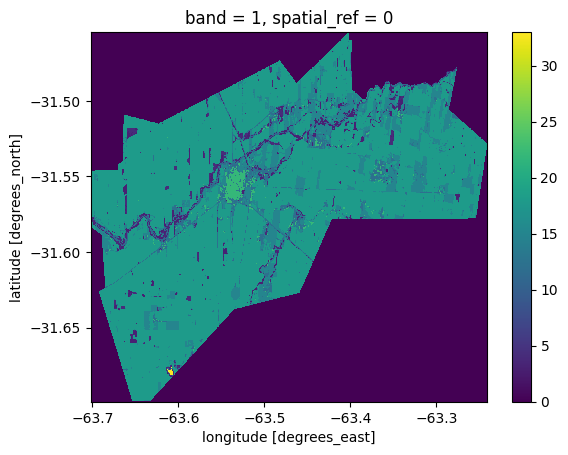

In [21]:
suelo_2022.plot()

In [22]:
# suelo_2022.rio.to_raster("/home/nissim/Documents/dev/fulbright/ciut-riesgo/data/villa_del_rosario/suelo_2022.tif")

In [23]:
# Define the detailed categories and colors
categories_detailed = {
    "Leñosa cerrada": {"ids": [3], "color": "#1f8d49"},
    "Leñosa abierta": {"ids": [4], "color": "#7dc975"},
    "Leñosa dispersa": {"ids": [45], "color": "#807a40"},
    "Leñosa inundable": {"ids": [6], "color": "#026975"},
    "Vegetación no leñosa inundable": {"ids": [11], "color": "#519799"},
    "Pastizal": {"ids": [12], "color": "#d6bc74"},
    "Estepa": {"ids": [63], "color": "#ebf8b5"},
    "Pastura": {"ids": [15], "color": "#edde8e"},
    "Agricultura": {"ids": [18], "color": "#e974ed"},
    "Plantación forestal": {"ids": [9], "color": "#7a5900"},
    "Cultivo arbustivo": {"ids": [36], "color": "#d082de"},
    "Mosaico agropecuario": {"ids": [21], "color": "#ffefc3"},
    "Área sin vegetación": {"ids": [22], "color": "#d4271e"},
    "Río, lago u océano": {"ids": [33], "color": "#2532e4"},
    "Hielo y nieve en superficie": {"ids": [34], "color": "#93dfe6"},
    "No observado": {"ids": [27], "color": "#ffffff"},
}

# You can also create grouped categories for broader analysis
categories_grouped = {
    "Vegetación leñosa": {
        "ids": [3, 4, 45, 6],
        "color": "#1f8d49",
        "subcategories": [
            "Leñosa cerrada",
            "Leñosa abierta",
            "Leñosa dispersa",
            "Leñosa inundable",
        ],
    },
    "Vegetación no leñosa": {
        "ids": [11, 12, 63],
        "color": "#d6bc74",
        "subcategories": ["Vegetación no leñosa inundable", "Pastizal", "Estepa"],
    },
    "Área agropecuaria": {
        "ids": [15, 18, 9, 36, 21],
        "color": "#ffefc3",
        "subcategories": [
            "Pastura",
            "Agricultura",
            "Plantación forestal",
            "Cultivo arbustivo",
            "Mosaico agropecuario",
        ],
    },
    "Área sin vegetación": {
        "ids": [22],
        "color": "#d4271e",
        "subcategories": ["Área sin vegetación"],
    },
    "Cuerpo de agua": {
        "ids": [33, 34],
        "color": "#2532e3",
        "subcategories": ["Río, lago u océano", "Hielo y nieve en superficie"],
    },
    "No observado": {
        "ids": [27],
        "color": "#ffffff",
        "subcategories": ["No observado"],
    },
}


# Function to categorize pixels
def categorize_pixel_detailed(value, categories):
    """Convert pixel value to detailed category name"""
    for category, info in categories.items():
        if value in info["ids"]:
            return category
    return "Other"


def categorize_pixel_grouped(value, categories):
    """Convert pixel value to grouped category name"""
    for category, info in categories.items():
        if value in info["ids"]:
            return category
    return "Other"

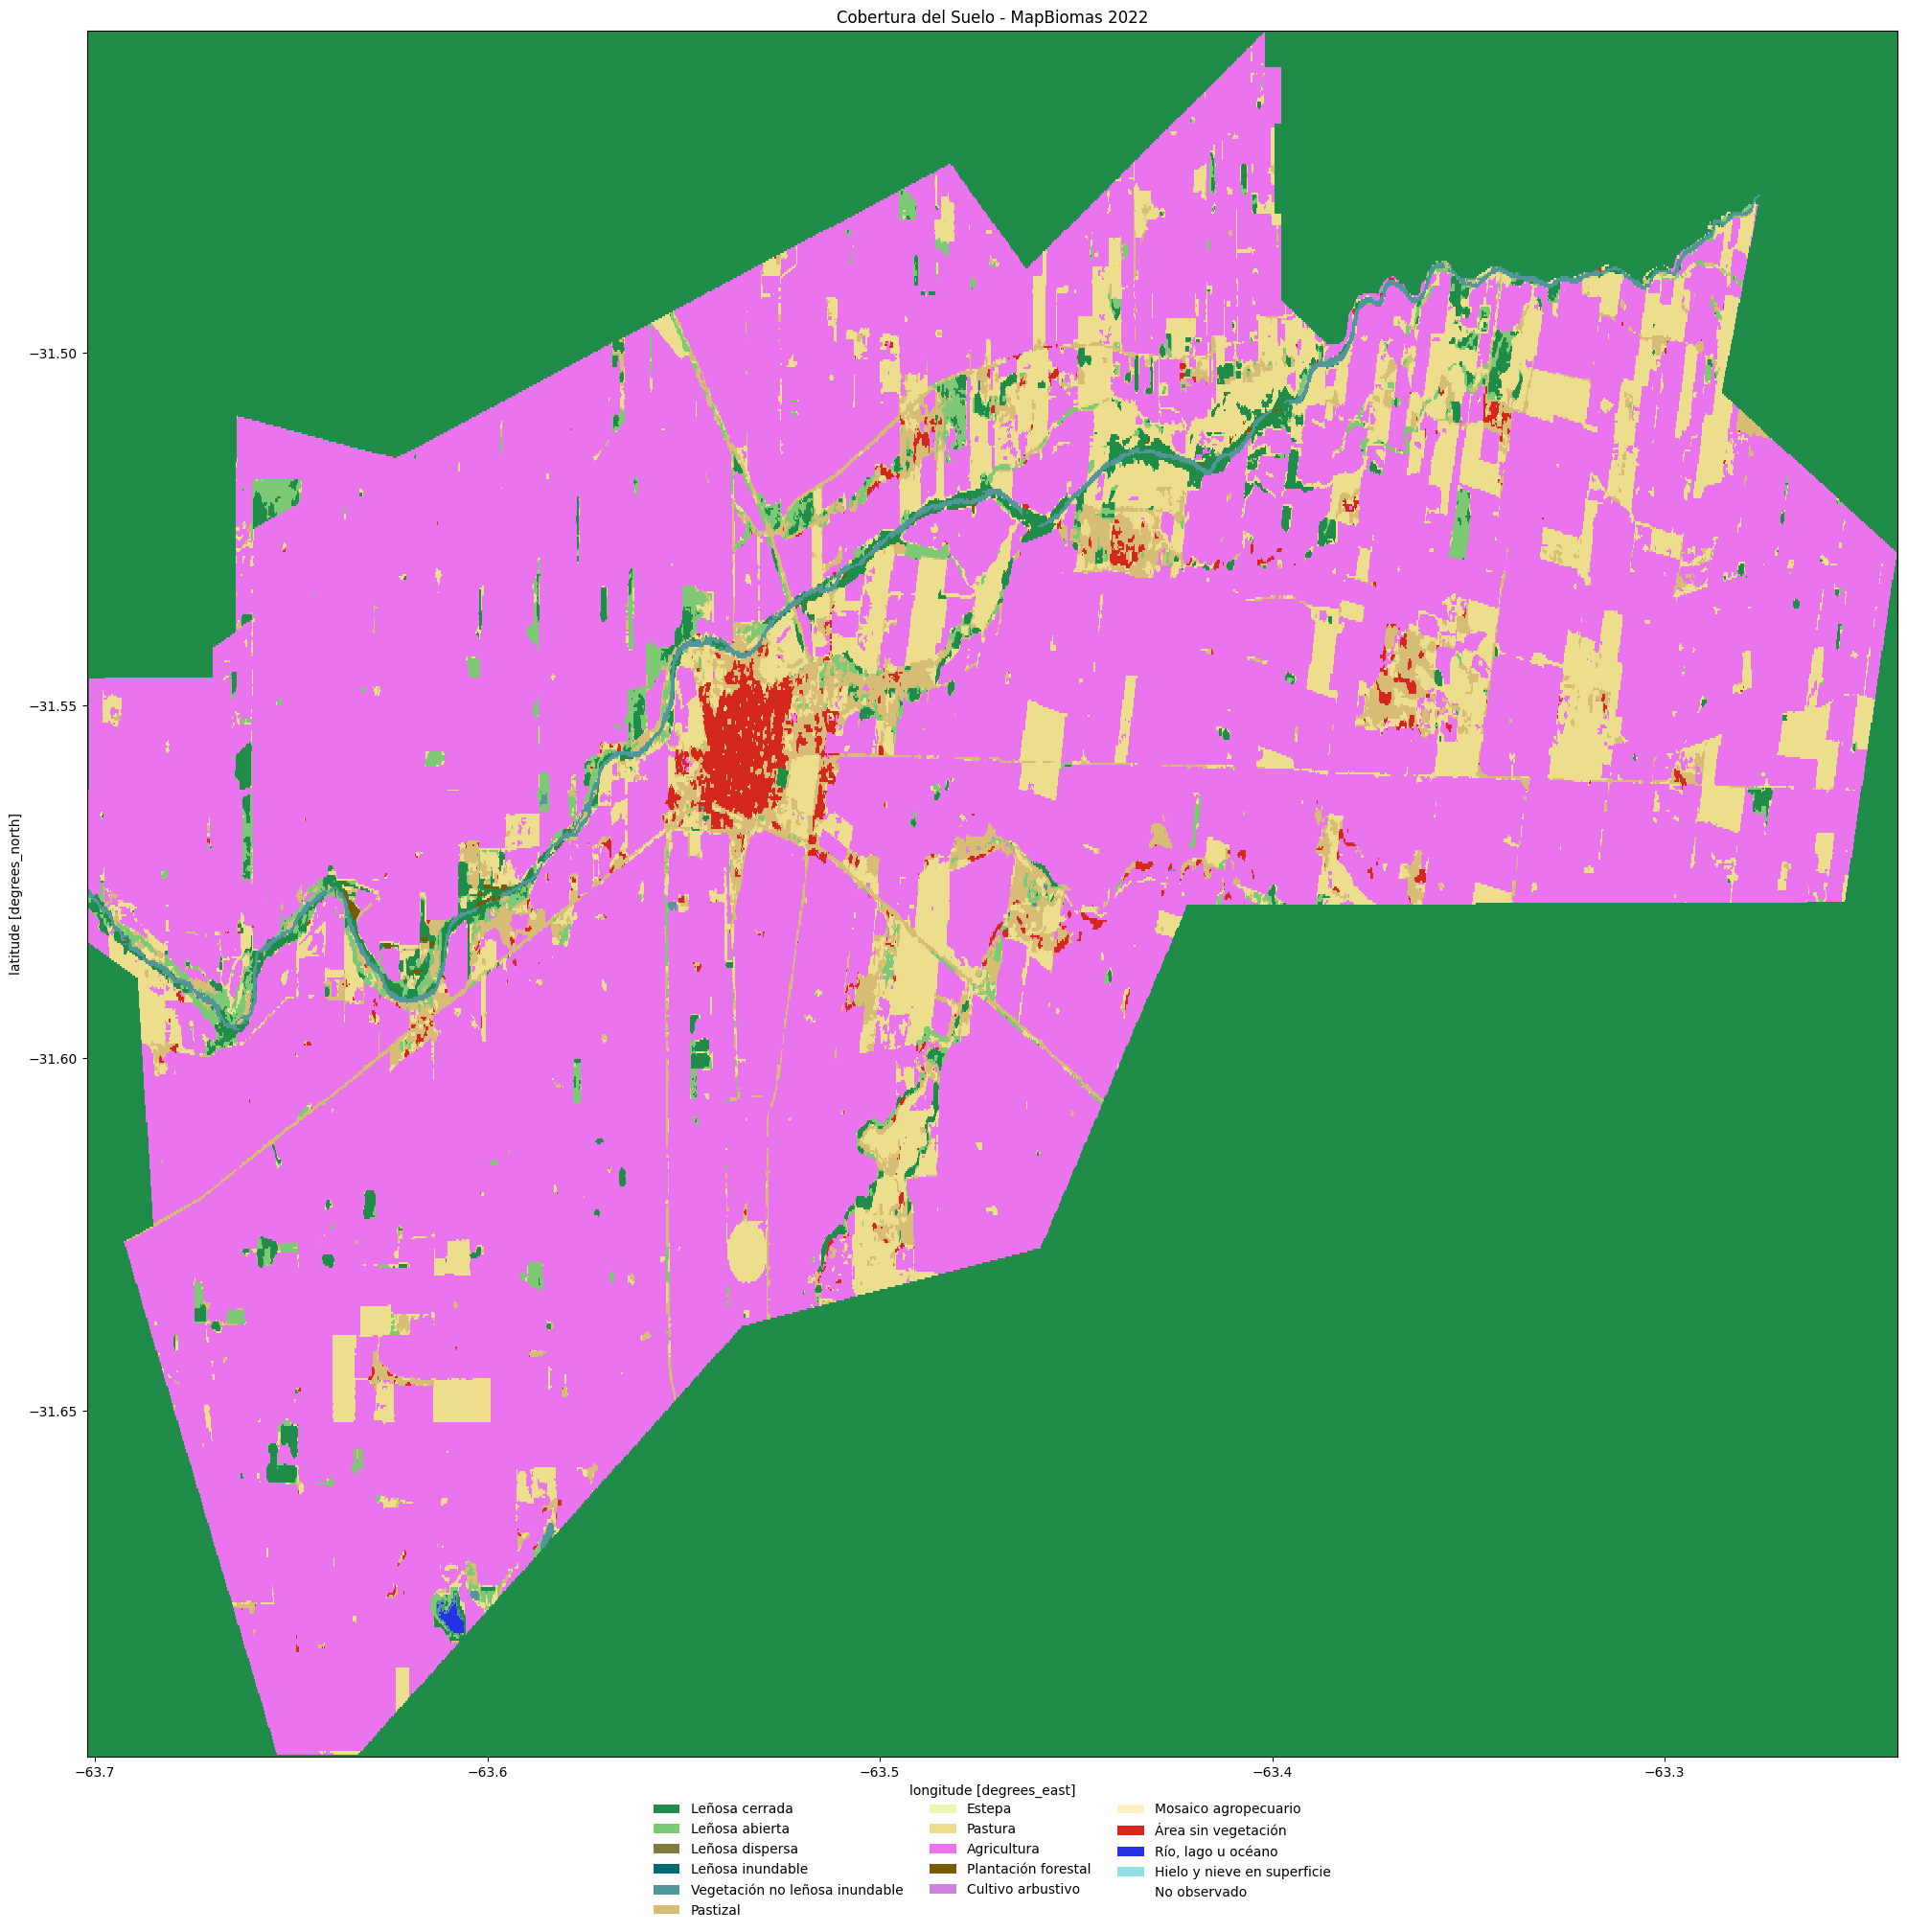

In [ ]:
# Create colormap from detailed categories
colors = {}
for category, info in categories_detailed.items():
    for pixel_id in info["ids"]:
        colors[pixel_id] = info["color"]

cmap = mcolors.ListedColormap([colors[i] for i in sorted(colors.keys())])
bounds = sorted(colors.keys())
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot
fig, ax = plt.subplots(figsize=(20, 20))

# Plot the raster
im = suelo_2022.plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=False)

# Create custom legend from detailed categories
legend_labels = {}
for category, info in categories_detailed.items():
    legend_labels[info["color"]] = category

# Add legend below the map
legend_elements = [
    plt.Rectangle((0, 0), 1, 1, facecolor=color, label=label)
    for color, label in legend_labels.items()
]
ax.legend(
    handles=legend_elements,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=3,
    frameon=False,
)

plt.title("Cobertura del Suelo - MapBiomas 2022")
plt.tight_layout()
plt.show()

In [25]:
# Calculate pixel counts for each category
unique_values, counts = np.unique(suelo_2022.values[0], return_counts=True)

# Create a mapping from pixel IDs to category names
id_to_category = {}
for category, info in categories_detailed.items():
    for pixel_id in info["ids"]:
        id_to_category[pixel_id] = category

# Calculate total pixels excluding no-data (ID 0)
valid_pixels = counts[unique_values != 0]
valid_values = unique_values[unique_values != 0]
total_pixels = np.sum(valid_pixels)
pixel_area_hectares = 0.09  # 30m x 30m = 900 m² = 0.09 hectares

# Create results list
results = []
for pixel_id, count in zip(valid_values, valid_pixels):
    if pixel_id in id_to_category:
        category = id_to_category[pixel_id]
        area_hectares = count * pixel_area_hectares
        percentage = (count / total_pixels) * 100
        results.append(
            {
                "Categoría": category,
                "ID": pixel_id,
                "Área (hectáreas)": f"{area_hectares:,.1f}",
                "Porcentaje (%)": f"{percentage:.1f}",
            }
        )

# Sort by area (descending)
results.sort(key=lambda x: float(x["Área (hectáreas)"].replace(",", "")), reverse=True)

# Create DataFrame and display
df = pd.DataFrame(results)
print("Cobertura del Suelo - MapBiomas 2022")
print("=" * 50)
print(df.to_string(index=False))
print(f"\nTotal área: {total_pixels * pixel_area_hectares:,.1f} hectáreas")

Cobertura del Suelo - MapBiomas 2022
                     Categoría  ID Área (hectáreas) Porcentaje (%)
                   Agricultura  18         54,481.7           77.6
                       Pastura  15          8,458.7           12.1
                      Pastizal  12          2,922.2            4.2
                Leñosa cerrada   3          1,473.0            2.1
                Leñosa abierta   4          1,430.6            2.0
           Área sin vegetación  22            865.5            1.2
Vegetación no leñosa inundable  11            513.1            0.7
           Plantación forestal   9             32.4            0.0
            Río, lago u océano  33             18.6            0.0

Total área: 70,195.9 hectáreas


In [ ]:
# Process data for all years
years = range(2000, 2023)
yearly_data = []

print("Processing MapBiomas data for all years...")

for year in tqdm(years):
    try:
        # Load the cloud GeoTIFF for the year
        suelo_ruta = f"https://storage.googleapis.com/mapbiomas-public/initiatives/argentina/collection-1/coverage/argentina_coverage_{year}.tif"

        suelo = rio.open_rasterio(
            suelo_ruta,
            chunks={"x": 1024, "y": 1024},
        )

        # Clip with from_disk=True for memory efficiency
        suelo_clipped = suelo.rio.clip(
            aoi.geometry.values,
            aoi.crs,
            from_disk=True,
        )

        # Get unique values and their counts
        values, counts = np.unique(suelo_clipped.values.flatten(), return_counts=True)

        # Exclude no-data values (pixel ID 0)
        valid_mask = values != 0
        valid_values = values[valid_mask]
        valid_counts = counts[valid_mask]

        # Create a mapping from pixel value to category
        value_to_category = {}
        for value in valid_values:
            if not np.isnan(value):
                value_to_category[int(value)] = categorize_pixel_grouped(
                    int(value), categories_grouped
                )

        # Calculate percentages for each category (excluding no-data)
        total_pixels = valid_counts.sum()
        year_percentages = {}

        for category in categories_grouped.keys():
            category_pixels = 0
            for value, count in zip(valid_values, valid_counts):
                if (
                    not np.isnan(value)
                    and value_to_category.get(int(value)) == category
                ):
                    category_pixels += count
            year_percentages[category] = (category_pixels / total_pixels) * 100

        year_percentages["year"] = year
        yearly_data.append(year_percentages)

        # Clean up memory
        del suelo, suelo_clipped

    except Exception as e:
        print(f"Error processing year {year}: {e}")
        continue

# Convert to DataFrame
df_yearly = pd.DataFrame(yearly_data)
df_yearly = df_yearly.set_index("year")

print("Data processing complete!")
print(f"Processed {len(df_yearly)} years")
print("\nSample data:")
print(df_yearly.head())

Processing MapBiomas data for all years...


100%|██████████| 23/23 [01:33<00:00,  4.05s/it]

Data processing complete!
Processed 23 years

Sample data:
      Vegetación leñosa  Vegetación no leñosa  Área agropecuaria  \
year                                                               
2000           6.144970              5.184145          88.022258   
2001           5.985345              5.017213          88.323685   
2002           5.655198              5.393388          88.296248   
2003           6.153817              4.694373          88.553570   
2004           4.742068              4.236526          90.387522   

      Área sin vegetación  Cuerpo de agua  No observado  
year                                                     
2000             0.645165        0.003462           0.0  
2001             0.673500        0.000256           0.0  
2002             0.654910        0.000256           0.0  
2003             0.598240        0.000000           0.0  
2004             0.633883        0.000000           0.0  


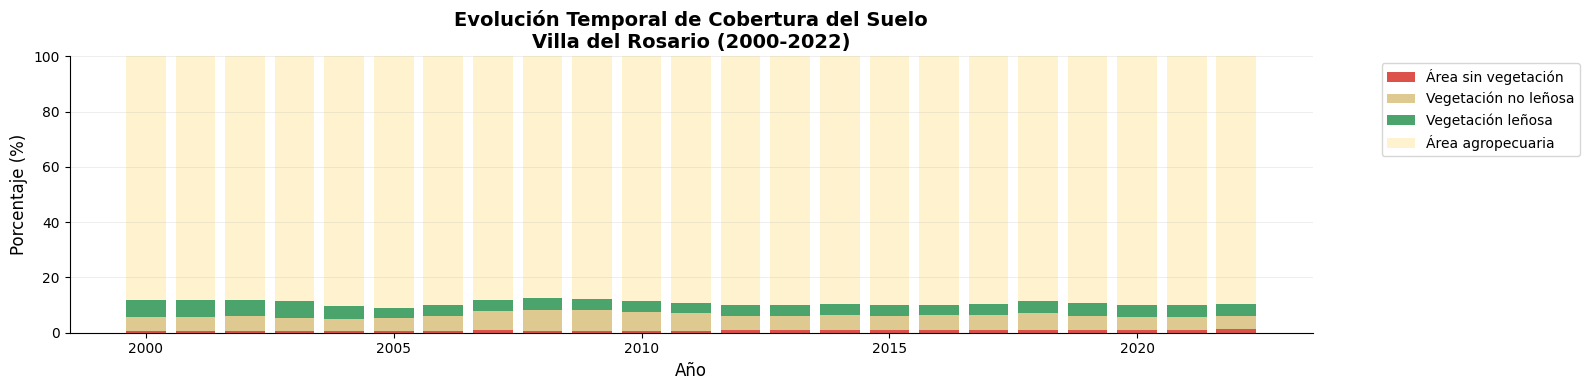

In [ ]:
# Set text as text objects, not paths
plt.rcParams["svg.fonttype"] = "none"

# Create stacked 100% bar chart
fig, ax = plt.subplots(figsize=(16, 4))

# Filter out categories with no data and exclude bodies of water
categories_with_data = []
colors_with_data = []

for category in categories_grouped.keys():
    if (
        category != "Cuerpo de agua" and df_yearly[category].sum() > 0
    ):  # Exclude bodies of water
        categories_with_data.append(category)
        colors_with_data.append(categories_grouped[category]["color"])

# Reorder categories to put 'Área agropecuaria' on top (reverse order for stacking)
category_order = [
    "Other",
    "No observado",
    "Área sin vegetación",
    "Vegetación no leñosa",
    "Vegetación leñosa",
    "Área agropecuaria",
]
ordered_categories = []
ordered_colors = []

for cat in category_order:
    if cat in categories_with_data:
        idx = categories_with_data.index(cat)
        ordered_categories.append(cat)
        ordered_colors.append(colors_with_data[idx])

# Add any remaining categories not in the order
for cat in categories_with_data:
    if cat not in ordered_categories:
        idx = categories_with_data.index(cat)
        ordered_categories.append(cat)
        ordered_colors.append(colors_with_data[idx])

# Create stacked bars
bottom = np.zeros(len(df_yearly))
bars = []

for i, category in enumerate(ordered_categories):
    values = df_yearly[category].values
    bars.append(
        ax.bar(
            df_yearly.index,
            values,
            bottom=bottom,
            color=ordered_colors[i],
            alpha=0.8,
            label=category,
        )
    )
    bottom += values

# Customize the plot
ax.set_xlabel("Año", fontsize=12)
ax.set_ylabel("Porcentaje (%)", fontsize=12)
ax.set_title(
    "Evolución Temporal de Cobertura del Suelo\nVilla del Rosario (2000-2022)",
    fontsize=14,
    fontweight="bold",
)

# Set y-axis to 100%
ax.set_ylim(0, 100)

# Add legend
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

# Remove top and right spines for minimalist look
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Set grid
ax.grid(True, alpha=0.3, linestyle="-", linewidth=0.5, axis="y")

plt.tight_layout()

# Save as SVG
# plt.savefig('/home/nissim/Documents/dev/fulbright/ciut-riesgo/data/villa_del_rosario/land_cover_timeseries.svg',
#             format='svg', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# Load the cloud GeoTIFF clipped to your GeoDataFrame
suelo_2000_ruta = "https://storage.googleapis.com/mapbiomas-public/initiatives/argentina/collection-1/coverage/argentina_coverage_2000.tif"

suelo_2000 = rio.open_rasterio(
    suelo_2000_ruta,
    chunks={"x": 1024, "y": 1024},
)

# Clip with from_disk=True for memory efficiency
suelo_2000 = suelo_2000.rio.clip(
    aoi.geometry.values,
    aoi.crs,
    from_disk=True,
)

In [ ]:
# Ensure both rasters have the same shape by clipping to the same extent
suelo_2000_clipped = suelo_2000.rio.clip(aoi.geometry.values, aoi.crs, from_disk=True)
suelo_2022_clipped = suelo_2022.rio.clip(aoi.geometry.values, aoi.crs, from_disk=True)

# Convert pixel values to grouped categories for both years
suelo_2000_cat = np.vectorize(
    lambda x: categorize_pixel_grouped(x, categories_grouped)
)(suelo_2000_clipped.values[0])
suelo_2022_cat = np.vectorize(
    lambda x: categorize_pixel_grouped(x, categories_grouped)
)(suelo_2022_clipped.values[0])

# Get unique categories (excluding no-data and bodies of water)
unique_2000 = np.unique(suelo_2000_cat)
unique_2022 = np.unique(suelo_2022_cat)

# Filter out unwanted categories
valid_categories = [
    "Área agropecuaria",
    "Vegetación leñosa",
    "Vegetación no leñosa",
    "Área sin vegetación",
]
existing_2000 = [cat for cat in unique_2000 if cat in valid_categories]
existing_2022 = [cat for cat in unique_2022 if cat in valid_categories]

# Calculate total pixels for percentage calculations
total_2000 = np.sum([np.sum(suelo_2000_cat == cat) for cat in existing_2000])
total_2022 = np.sum([np.sum(suelo_2022_cat == cat) for cat in existing_2022])

# Create transition matrix
transition_matrix = {}
for cat_2000 in existing_2000:
    transition_matrix[cat_2000] = {}
    mask_2000 = suelo_2000_cat == cat_2000
    for cat_2022 in existing_2022:
        mask_2022 = suelo_2022_cat == cat_2022
        transition_count = np.sum(mask_2000 & mask_2022)
        if transition_count > 0:
            transition_matrix[cat_2000][cat_2022] = transition_count

# Prepare Sankey data
source = []
target = []
value = []
node_labels = []
node_colors = []
link_colors = []

# Add 2000 nodes with percentages
for i, cat in enumerate(existing_2000):
    count = np.sum(suelo_2000_cat == cat)
    percentage = (count / total_2000) * 100
    node_labels.append(f"{cat}<br>2000<br>({percentage:.1f}%)")
    node_colors.append(categories_grouped[cat]["color"])

# Add 2022 nodes with percentages
for i, cat in enumerate(existing_2022):
    count = np.sum(suelo_2022_cat == cat)
    percentage = (count / total_2022) * 100
    node_labels.append(f"{cat}<br>2022<br>({percentage:.1f}%)")
    node_colors.append(categories_grouped[cat]["color"])

# Create links based on actual transitions
for cat_2000, transitions in transition_matrix.items():
    source_idx = existing_2000.index(cat_2000)
    for cat_2022, count in transitions.items():
        target_idx = len(existing_2000) + existing_2022.index(cat_2022)

        source.append(source_idx)
        target.append(target_idx)
        value.append(count)
        link_colors.append(categories_grouped[cat_2000]["color"])

# Create Sankey diagram
fig = go.Figure(
    data=[
        go.Sankey(
            node=dict(
                pad=15,
                thickness=20,
                line=dict(color="black", width=0.5),
                label=node_labels,
                color=node_colors,
            ),
            link=dict(source=source, target=target, value=value, color=link_colors),
        )
    ]
)

fig.update_layout(
    title_text="Transiciones Reales de Cobertura del Suelo (2000 → 2022)",
    font_size=12,
    width=800,
    height=800,
)

# Try to save as PDF
# try:
#     fig.write_image('/home/nissim/Documents/dev/fulbright/ciut-riesgo/data/villa_del_rosario/sankey_transitions.pdf',
#                     format='pdf', width=800, height=800)
#     print("PDF saved successfully!")
# except Exception as e:
#     print(f"PDF export failed: {e}")
#     # Try SVG as fallback
#     try:
#         fig.write_image('/home/nissim/Documents/dev/fulbright/ciut-riesgo/data/villa_del_rosario/sankey_transitions.svg',
#                         format='svg', width=800, height=800)
#         print("SVG saved successfully!")
#     except Exception as e2:
#         print(f"SVG also failed: {e2}")

fig.show()

/home/nissim/Documents/dev/fulbright/ciut-riesgo/.venv/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/home/nissim/Documents/dev/fulbright/ciut-riesgo/.venv/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [15]:
# Calculate total hectares for each major class
pixel_area_hectares = 0.09  # 30m x 30m = 900 m² = 0.09 hectares

print("TOTAL HECTARES POR CLASE PRINCIPAL")
print("=" * 50)

print("\n2000:")
for cat in existing_2000:
    count = np.sum(suelo_2000_cat == cat)
    hectares = count * pixel_area_hectares
    percentage = (count / total_2000) * 100
    print(f"{cat}: {hectares:,.1f} ha ({percentage:.1f}%)")

print("\n2022:")
for cat in existing_2022:
    count = np.sum(suelo_2022_cat == cat)
    hectares = count * pixel_area_hectares
    percentage = (count / total_2022) * 100
    print(f"{cat}: {hectares:,.1f} ha ({percentage:.1f}%)")

# Calculate total area
total_hectares_2000 = total_2000 * pixel_area_hectares
total_hectares_2022 = total_2022 * pixel_area_hectares

print("\nTOTAL ÁREA:")
print(f"2000: {total_hectares_2000:,.1f} ha")
print(f"2022: {total_hectares_2022:,.1f} ha")

TOTAL HECTARES POR CLASE PRINCIPAL

2000:
Vegetación leñosa: 4,313.5 ha (6.1%)
Vegetación no leñosa: 3,639.1 ha (5.2%)
Área agropecuaria: 61,788.1 ha (88.0%)
Área sin vegetación: 452.9 ha (0.6%)

2022:
Vegetación leñosa: 2,903.7 ha (4.1%)
Vegetación no leñosa: 3,435.3 ha (4.9%)
Área agropecuaria: 62,972.8 ha (89.7%)
Área sin vegetación: 865.5 ha (1.2%)

TOTAL ÁREA:
2000: 70,193.5 ha
2022: 70,177.3 ha


In [ ]:
# Create colormap from detailed categories
colors = {}
for category, info in categories_detailed.items():
    for pixel_id in info["ids"]:
        colors[pixel_id] = info["color"]

cmap = mcolors.ListedColormap([colors[i] for i in sorted(colors.keys())])
bounds = sorted(colors.keys())
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot
fig, ax = plt.subplots(figsize=(20, 20))

# Plot the raster
im = suelo_2000.plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=False)

# Create custom legend from detailed categories
legend_labels = {}
for category, info in categories_detailed.items():
    legend_labels[info["color"]] = category

# Add legend below the map
legend_elements = [
    plt.Rectangle((0, 0), 1, 1, facecolor=color, label=label)
    for color, label in legend_labels.items()
]
ax.legend(
    handles=legend_elements,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=3,
    frameon=False,
)

plt.title("Cobertura del Suelo - MapBiomas 2000")
plt.tight_layout()
plt.show()

In [ ]:
# Calculate pixel counts for each category
unique_values, counts = np.unique(suelo_2000.values[0], return_counts=True)

# Create a mapping from pixel IDs to category names
id_to_category = {}
for category, info in categories_detailed.items():
    for pixel_id in info["ids"]:
        id_to_category[pixel_id] = category

# Calculate total pixels and area per pixel (assuming 100m resolution)
total_pixels = np.sum(counts)
pixel_area_hectares = 0.01  # 100m x 100m = 1 hectare

# Create results list
results = []
for pixel_id, count in zip(unique_values, counts):
    if pixel_id in id_to_category:
        category = id_to_category[pixel_id]
        area_hectares = count * pixel_area_hectares
        percentage = (count / total_pixels) * 100
        results.append(
            {
                "Categoría": category,
                "ID": pixel_id,
                "Área (hectáreas)": f"{area_hectares:,.1f}",
                "Porcentaje (%)": f"{percentage:.1f}",
            }
        )

# Sort by area (descending)
results.sort(key=lambda x: float(x["Área (hectáreas)"].replace(",", "")), reverse=True)

# Create DataFrame and display
df = pd.DataFrame(results)
print("Cobertura del Suelo - MapBiomas 2000")
print("=" * 50)
print(df.to_string(index=False))
print(f"\nTotal área: {total_pixels * pixel_area_hectares:,.1f} hectáreas")

In [ ]:
def categorize_pixel_grouped(value, categories):
    """Convert pixel value to grouped category name"""
    for category, info in categories.items():
        if value in info["ids"]:
            return category
    return "Other"


# Get the raw pixel values
suelo_2000_values = suelo_2000.values[0]
suelo_2022_values = suelo_2022.values[0]

# Convert to grouped categories
suelo_2000_cat = np.vectorize(
    lambda x: categorize_pixel_grouped(x, categories_grouped)
)(suelo_2000_values)
suelo_2022_cat = np.vectorize(
    lambda x: categorize_pixel_grouped(x, categories_grouped)
)(suelo_2022_values)

# Create transition map
transition_map = np.zeros_like(suelo_2000_cat, dtype=int)

# Only process pixels that actually changed
changed_mask = suelo_2000_values != suelo_2022_values

# Transition 1: Agriculture/non-vegetated → Forest/natural (natural regrowth)
mask1 = (
    changed_mask
    & (
        (suelo_2000_cat == "Área agropecuaria")
        | (suelo_2000_cat == "Área sin vegetación")
    )
    & (
        (suelo_2022_cat == "Vegetación leñosa")
        | (suelo_2022_cat == "Vegetación no leñosa")
    )
)
transition_map[mask1] = 1

# Transition 2: Forest/natural → Agriculture/non-vegetated
mask2 = (
    changed_mask
    & (
        (suelo_2000_cat == "Vegetación leñosa")
        | (suelo_2000_cat == "Vegetación no leñosa")
    )
    & (
        (suelo_2022_cat == "Área agropecuaria")
        | (suelo_2022_cat == "Área sin vegetación")
    )
)
transition_map[mask2] = 2

# Transition 3: Water gain
mask3 = (
    changed_mask
    & (suelo_2000_cat != "Cuerpo de agua")
    & (suelo_2022_cat == "Cuerpo de agua")
)
transition_map[mask3] = 3

# Transition 4: Water loss
mask4 = (
    changed_mask
    & (suelo_2000_cat == "Cuerpo de agua")
    & (suelo_2022_cat != "Cuerpo de agua")
)
transition_map[mask4] = 4

# Transition 5: Forest plantation gain (only specific plantation types)
mask5 = (
    changed_mask
    & (suelo_2000_cat == "Área agropecuaria")
    & (suelo_2022_cat == "Vegetación leñosa")
    & (suelo_2022_values == 9)
)
transition_map[mask5] = 5

# Transition 6: Other changes (catch-all for remaining changed pixels)
mask6 = changed_mask & (transition_map == 0)
transition_map[mask6] = 6

# Transition 7: No change
transition_map[~changed_mask] = 7

# Colors
colors = {
    0: "#cccccc",  # Unclassified
    1: "#06ff00",  # Agriculture → Forest/natural (regeneration)
    2: "#ff0000",  # Forest/natural → Agriculture
    3: "#0066cc",  # Water gain
    4: "#ff6600",  # Water loss
    5: "#8a2be2",  # Forest plantation gain
    6: "#ffa500",  # Other changes
    7: "#aaa9a9",  # No change
}

labels = {
    0: "No clasificado",
    1: "Agricultura → Forestal/natural",
    2: "Forestal/natural → Agricultura",
    3: "Ganancia de agua",
    4: "Pérdida de agua",
    5: "Ganancia plantación forestal",
    6: "Otros cambios",
    7: "Sin cambio",
}

# Create colormap
cmap = mcolors.ListedColormap([colors[i] for i in sorted(colors.keys())])
bounds = sorted(colors.keys())
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot
fig, ax = plt.subplots(figsize=(15, 15))
im = ax.imshow(transition_map, cmap=cmap, norm=norm)

# Legend
legend_elements = [
    plt.Rectangle((0, 0), 1, 1, facecolor=colors[i], label=labels[i])
    for i in sorted(colors.keys())
]
ax.legend(
    handles=legend_elements,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=2,
    frameon=False,
)

plt.title("Transiciones de Cobertura del Suelo (2000-2022)")
plt.tight_layout()
plt.show()

In [ ]:
def categorize_pixel_grouped(value, categories):
    """Convert pixel value to grouped category name"""
    for category, info in categories.items():
        if value in info["ids"]:
            return category
    return "Other"


# Convert pixel values to grouped categories
suelo_2000_cat = np.vectorize(
    lambda x: categorize_pixel_grouped(x, categories_grouped)
)(suelo_2000.values[0])
suelo_2022_cat = np.vectorize(
    lambda x: categorize_pixel_grouped(x, categories_grouped)
)(suelo_2022.values[0])

# Calculate pixel counts for each category
unique_2000, counts_2000 = np.unique(suelo_2000_cat, return_counts=True)
unique_2022, counts_2022 = np.unique(suelo_2022_cat, return_counts=True)

# Filter out 'Other' and get only categories that exist
existing_2000 = unique_2000[unique_2000 != "Other"]
existing_2022 = unique_2022[unique_2022 != "Other"]

# Calculate total pixels
total_2000 = sum(counts_2000[unique_2000 != "Other"])
total_2022 = sum(counts_2022[unique_2022 != "Other"])

# Create transition matrix
transition_matrix = {}
for cat_2000 in existing_2000:
    transition_matrix[cat_2000] = {}
    mask_2000 = suelo_2000_cat == cat_2000
    for cat_2022 in existing_2022:
        mask_2022 = suelo_2022_cat == cat_2022
        transition_count = np.sum(mask_2000 & mask_2022)
        if transition_count > 0:
            transition_matrix[cat_2000][cat_2022] = transition_count

# Prepare data for Sankey diagram
source = []
target = []
value = []
node_labels = []
node_colors = []

# Add 2000 categories
for cat in existing_2000:
    count = counts_2000[unique_2000 == cat][0]
    percentage = (count / total_2000) * 100
    node_labels.append(f"{cat}<br>({percentage:.1f}%)")
    node_colors.append(categories_grouped[cat]["color"])

# Add 2022 categories
for cat in existing_2022:
    count = counts_2022[unique_2022 == cat][0]
    percentage = (count / total_2022) * 100
    node_labels.append(f"{cat}<br>({percentage:.1f}%)")
    node_colors.append(categories_grouped[cat]["color"])

# Create links
link_colors = []
for cat_2000, transitions in transition_matrix.items():
    for cat_2022, count in transitions.items():
        source_idx = node_labels.index(
            f"{cat_2000}<br>({(counts_2000[unique_2000 == cat_2000][0] / total_2000) * 100:.1f}%)"
        )
        target_idx = node_labels.index(
            f"{cat_2022}<br>({(counts_2022[unique_2022 == cat_2022][0] / total_2022) * 100:.1f}%)"
        )

        source.append(source_idx)
        target.append(target_idx)
        value.append(count)
        link_colors.append(categories_grouped[cat_2000]["color"])

# Create Sankey diagram
fig = go.Figure(
    data=[
        go.Sankey(
            node=dict(
                pad=15,
                thickness=20,
                line=dict(color="black", width=0.5),
                label=node_labels,
                color=node_colors,
            ),
            link=dict(source=source, target=target, value=value, color=link_colors),
        )
    ]
)

fig.update_layout(
    title_text="Transiciones de Cobertura del Suelo (2000-2022)",
    font_size=12,
    width=1000,
    height=600,
)

fig.show()

## Loss to fire

In [ ]:
# Load the cloud GeoTIFF clipped to your GeoDataFrame
perdida_a_fuego_ruta = "https://glad.umd.edu/users/Alexandra/Fire_GFL_data/2001-24/LAM_fire_forest_loss_2001-24.tif"

perdida_a_fuego = rio.open_rasterio(
    perdida_a_fuego_ruta,
    chunks={"x": 1024, "y": 1024},
)

# Clip with from_disk=True for memory efficiency
perdida_a_fuego = perdida_a_fuego.rio.clip(
    aoi.buffer(1000 * 20).geometry.values,
    aoi.crs,
    from_disk=True,
)

In [8]:
perdida_a_fuego.rio.to_raster(
    "/home/nissim/Documents/dev/fulbright/ciut-riesgo/data/villa_del_rosario/datos/bosque_perdido_a_fuego_2001-24.tif"
)

In [18]:
perdida_a_fuego

<xarray.DataArray (band: 1, y: 979, x: 1845)> Size: 2MB
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], shape=(1, 979, 1845), dtype=uint8)
Coordinates:
  * x            (x) float64 15kB -63.7 -63.7 -63.7 ... -63.24 -63.24 -63.24
  * y            (y) float64 8kB -31.45 -31.45 -31.45 ... -31.7 -31.7 -31.7
  * band         (band) int64 8B 1
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    LAYER_TYPE:     athematic
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      Layer_1

In [20]:
perdida_a_fuego.band.values

array([1])

In [24]:
np.unique(perdida_a_fuego)

array([0, 1, 2, 3, 4], dtype=uint8)

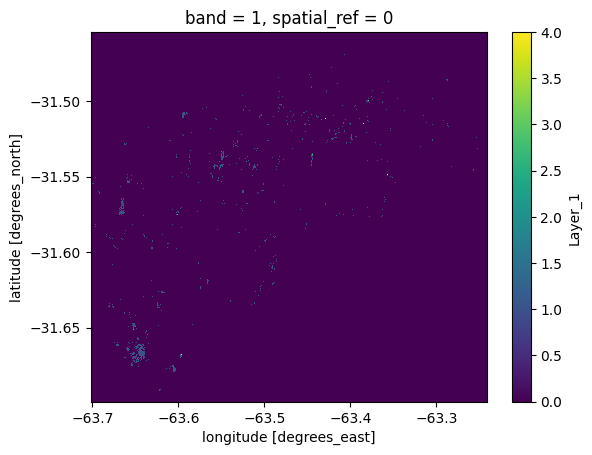

In [17]:
perdida_a_fuego.plot()

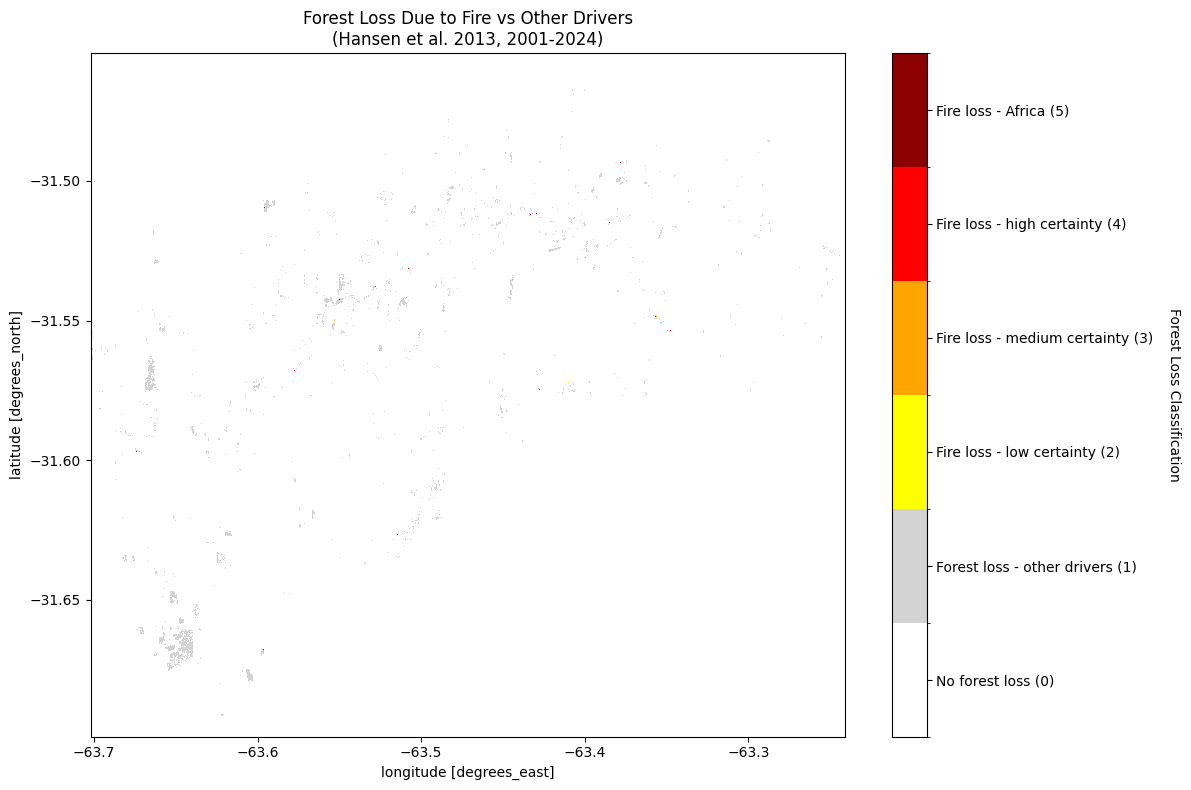

In [ ]:
# Define the color map and labels based on the classification
colors = ["white", "lightgray", "yellow", "orange", "red", "darkred"]
labels = [
    "No forest loss (0)",
    "Forest loss - other drivers (1)",
    "Fire loss - low certainty (2)",
    "Fire loss - medium certainty (3)",
    "Fire loss - high certainty (4)",
    "Fire loss - Africa (5)",
]

# Create custom colormap
cmap = mcolors.ListedColormap(colors)
bounds = [0, 1, 2, 3, 4, 5, 6]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot the data
fig, ax = plt.subplots(figsize=(12, 8))
im = perdida_a_fuego.plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=False)

# Add colorbar with custom labels
cbar = plt.colorbar(im, ax=ax, ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5])
cbar.set_ticklabels(labels)
cbar.set_label("Forest Loss Classification", rotation=270, labelpad=20)

# Add title
plt.title("Forest Loss Due to Fire vs Other Drivers\n(Hansen et al. 2013, 2001-2024)")

plt.tight_layout()
plt.show()

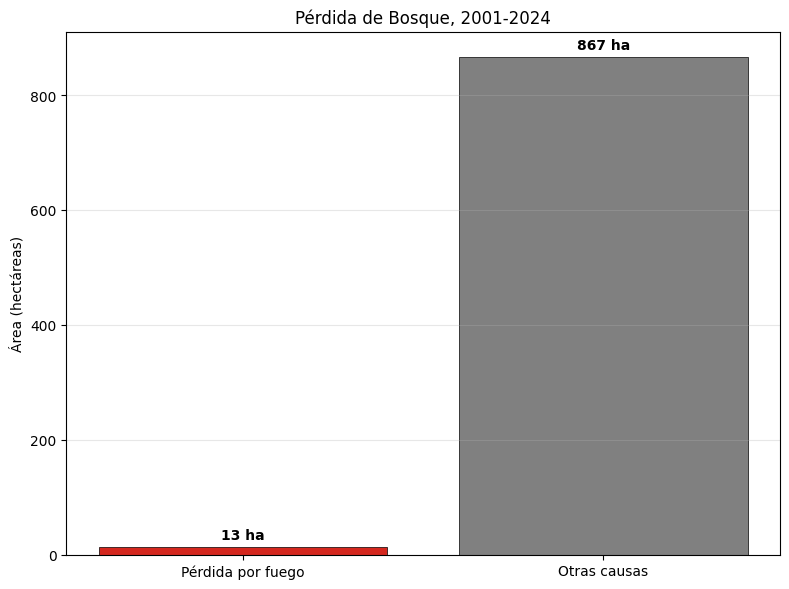

Resumen de Pérdida de Bosque:
Pérdida por fuego        :       13 ha
Otras causas             :      867 ha
Total pérdida            :      880 ha


In [ ]:
# Calculate pixel counts for each category
unique_values, counts = np.unique(perdida_a_fuego, return_counts=True)

# Calculate areas (assuming 30m resolution from Hansen data)
pixel_area = 30 * 30  # 30m x 30m = 900 m²
areas_hectares = counts * pixel_area / 10000  # Convert to hectares

# Group into fire vs non-fire categories (ONLY actual forest loss)
fire_categories = [2, 3, 4, 5]  # Low, medium, high certainty fire, Africa fire
non_fire_categories = [1]  # Other drivers (excluding no loss = 0)

fire_area = sum(
    areas_hectares[i] for i, val in enumerate(unique_values) if val in fire_categories
)
non_fire_area = sum(
    areas_hectares[i]
    for i, val in enumerate(unique_values)
    if val in non_fire_categories
)

# Create labels in Spanish
category_labels = ["Pérdida por fuego", "Otras causas"]
areas = [fire_area, non_fire_area]
colors = ["#d4271e", "#808080"]  # Red for fire, gray for other

# Create the bar plot
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(category_labels, areas, color=colors, edgecolor="black", linewidth=0.5)

# Add value labels on top of bars
for bar, area in zip(bars, areas):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + max(areas) * 0.01,
        f"{area:.0f} ha",
        ha="center",
        va="bottom",
        fontweight="bold",
    )

# Customize the plot
ax.set_ylabel("Área (hectáreas)")
ax.set_title("Pérdida de Bosque, 2001-2024")
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig(
    "/home/nissim/Documents/dev/fulbright/ciut-riesgo/data/villa_del_rosario/mapas/forest_loss_fire_vs_other.svg",
    format="svg",
    dpi=300,
    bbox_inches="tight",
)

plt.show()

# Print summary statistics
print("Resumen de Pérdida de Bosque:")
print("=" * 35)
print(f"{'Pérdida por fuego':25}: {fire_area:8.0f} ha")
print(f"{'Otras causas':25}: {non_fire_area:8.0f} ha")
total_loss = fire_area + non_fire_area
print(f"{'Total pérdida':25}: {total_loss:8.0f} ha")

<Figure size 640x480 with 0 Axes>

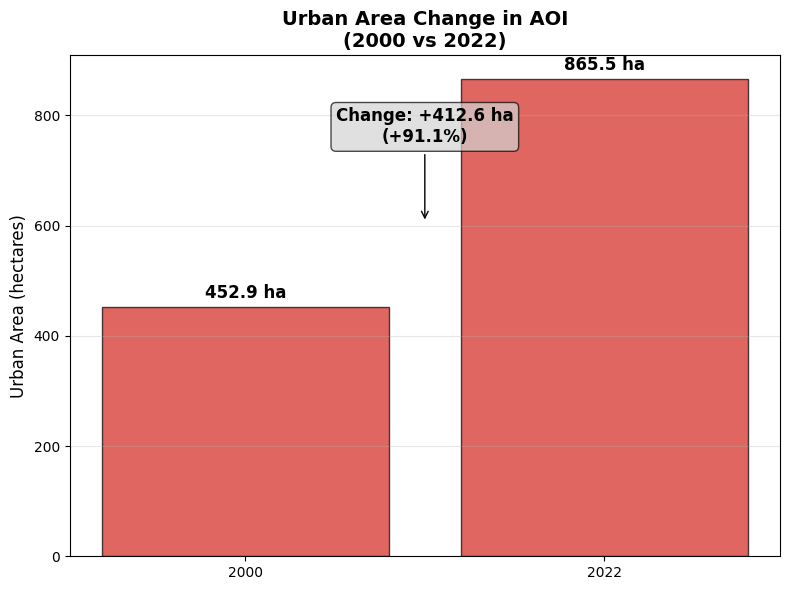

URBAN AREA CHANGE SUMMARY
2000: 452.9 ha
2022: 865.5 ha
Change: +412.6 ha (+91.1%)


In [ ]:
# Calculate urban area (Área sin vegetación) for both years
urban_2000 = np.sum(suelo_2000_cat == "Área sin vegetación") * pixel_area_hectares
urban_2022 = np.sum(suelo_2022_cat == "Área sin vegetación") * pixel_area_hectares

# Calculate change
urban_change = urban_2022 - urban_2000
percent_change = (urban_change / urban_2000) * 100 if urban_2000 > 0 else 0

# Create the bar chart
fig, ax = plt.subplots(figsize=(8, 6))

years = ["2000", "2022"]
urban_areas = [urban_2000, urban_2022]
colors = ["#d4271e", "#d4271e"]  # Same color for both bars

bars = ax.bar(
    years, urban_areas, color=colors, alpha=0.7, edgecolor="black", linewidth=1
)

# Add value labels on top of bars
for bar, area in zip(bars, urban_areas):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + max(urban_areas) * 0.01,
        f"{area:,.1f} ha",
        ha="center",
        va="bottom",
        fontweight="bold",
        fontsize=12,
    )

# Add change annotation
ax.annotate(
    f"Change: {urban_change:+,.1f} ha\n({percent_change:+.1f}%)",
    xy=(0.5, max(urban_areas) * 0.7),
    xytext=(0.5, max(urban_areas) * 0.9),
    ha="center",
    va="center",
    fontsize=12,
    fontweight="bold",
    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.7),
    arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0"),
)

# Customize the plot
ax.set_ylabel("Urban Area (hectares)", fontsize=12)
ax.set_title("Urban Area Change in AOI\n(2000 vs 2022)", fontsize=14, fontweight="bold")
ax.grid(axis="y", alpha=0.3)

# Format y-axis to show thousands separator
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:,.0f}"))

plt.tight_layout()

plt.savefig(
    "/home/nissim/Documents/dev/fulbright/ciut-riesgo/data/villa_del_rosario/mapas/urban_expansion.svg",
    format="svg",
    dpi=300,
    bbox_inches="tight",
)

plt.show()

# Print summary
print("URBAN AREA CHANGE SUMMARY")
print("=" * 30)
print(f"2000: {urban_2000:,.1f} ha")
print(f"2022: {urban_2022:,.1f} ha")
print(f"Change: {urban_change:+,.1f} ha ({percent_change:+.1f}%)")